In [1]:
%load_ext autoreload
%autoreload 2

## Preamble

In [2]:
import numpy as np

In [3]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.lines as pltl
import matplotlib.ticker as pltt


In [4]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler,PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [5]:
from lineartree import LinearTreeRegressor
from lineartree._classes import CRITERIA

def mape(model, X, y, weights=None, **largs):
    """Mean Absolute Percentage Error"""

    pred = model.predict(X)
    return mean_absolute_percentage_error(y,pred,weights)
    
CRITERIA['mae'] = mape # have to override because extensibility is bad

In [6]:
from utils import Example2D, NamedFunc, MonomialFeatures, roughplot2D, step, evolve, SaveBest, EpochProgbar, animatedplot2D
from evaluate import evaluate2D
from models import SymmetricRidge, tfNSymmetricBuiltin_Regressor, tfNSymmetricBuiltin_NormRegressor

In [7]:
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 24
rcParams["mathtext.fontset"]  = 'dejavuserif'
plt_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Data

In [8]:
mat2 = Example2D("plate/plate_2_20_20")

### Separate reduction

In [9]:
npod_x = 4
npod_eps = 5

In [10]:
mat2.reduce_components(npod_eps,to_reduce=['eps'],decomposable="self.pepspeps")
t = mat2.t

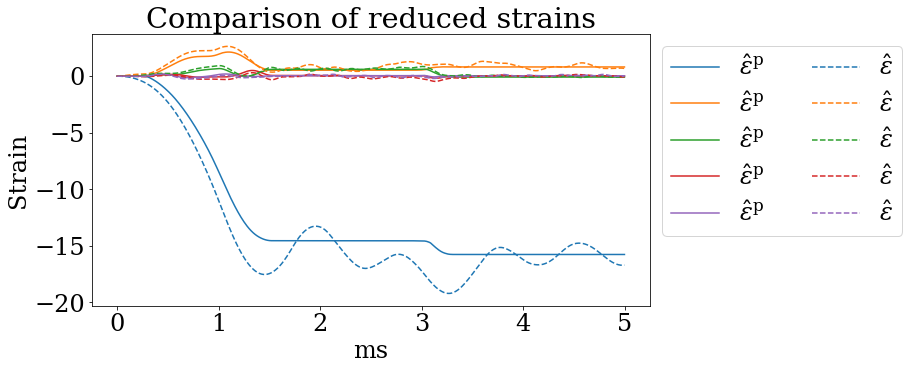

In [11]:
plt.figure(figsize=(10,5))
plt.plot(t,mat2.peps_r,label=r"$\hat{\epsilon}^{\mathrm{p}}$");
plt.gca().set_prop_cycle(None)
plt.plot(t,mat2.epsbar_r,'--',label=r"$\hat{{\epsilon}}$");
plt.legend(loc='upper left',bbox_to_anchor=(1,1),ncol=2);
plt.ylabel("Strain")
plt.xlabel("ms");
plt.title(r"Comparison of reduced strains");

In [12]:
mat2.reduce_components(npod_x,to_reduce='x')


## Strain models

0.14523963739099793

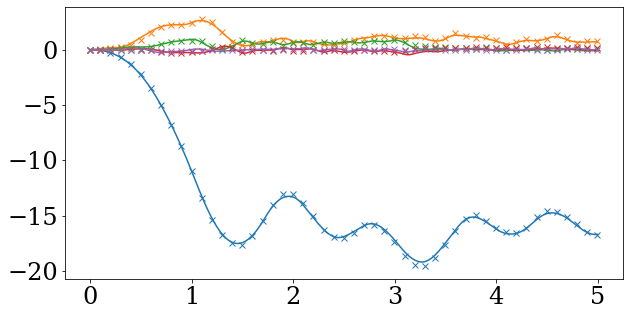

In [18]:
strain_ridge_x = Ridge(alpha=0.1,fit_intercept=False)
x = mat2.xr-mat2.xr[0]
y = mat2.epsbar_r
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4,random_state=42,shuffle=False)
strain_ridge_x.fit(x_train, y_train)
y_trial = strain_ridge_x.predict(x)
plt.figure(figsize=(10,5))
plt.plot(t,y)
plt.gca().set_prop_cycle(None)
plt.plot(t[::10],y_trial[::10],'x')
strain_ridge_x.score(x_test,y_test)

0.8502381434273829

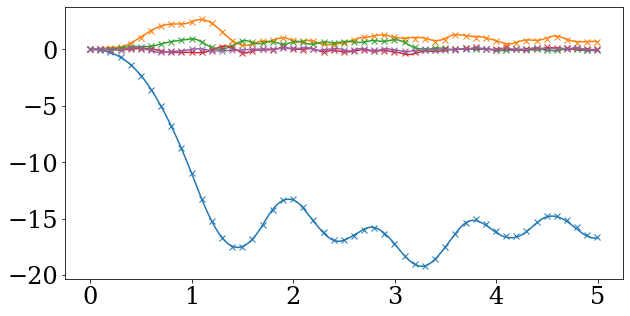

In [19]:
strain_ridge_xeps = Ridge(alpha=0.5,fit_intercept=False)
x = np.hstack([np.pad(mat2.epsbar_r[:-1],((1,0),(0,0)),'edge'), mat2.xr-mat2.xr[0]])
y = mat2.epsbar_r
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4,random_state=42,shuffle=False)
strain_ridge_xeps.fit(x_train, y_train)
y_trial = strain_ridge_xeps.predict(x)
plt.figure(figsize=(10,5))
plt.plot(t,y)
plt.gca().set_prop_cycle(None)
plt.plot(t[::10],y_trial[::10],'x')
strain_ridge_xeps.score(x_test,y_test)

## Yield models

-10.480512822021316

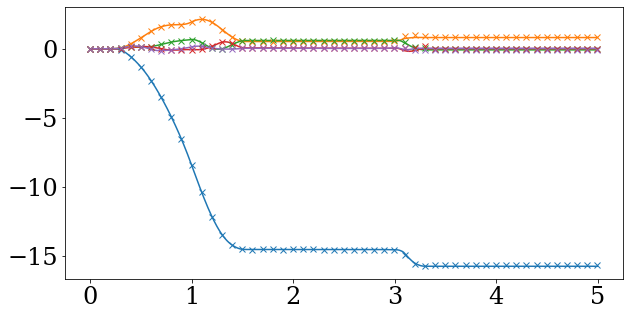

In [20]:
yield_lt_epspeps_epspepsdiff = LinearTreeRegressor(#LinearRegression(fit_intercept=False),
                                    Ridge(alpha=0.01, fit_intercept=False),
                                    criterion='mae',
                                    min_samples_leaf=4*npod_x,
                                    max_depth=npod_eps,
                                    linear_features=range(2*npod_eps),
                                    split_features=range(3*npod_eps))
peps_shift = np.pad(mat2.peps_r[:-1],((1,0),(0,0)),'edge')
x = np.hstack([mat2.epsbar_r, peps_shift, mat2.epsbar_r - peps_shift ])
y = mat2.peps_r
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4,random_state=42,shuffle=False)
yield_lt_epspeps_epspepsdiff.fit(x_train, y_train)
y_trial = yield_lt_epspeps_epspepsdiff.predict(x)
plt.figure(figsize=(10,5))
plt.plot(t,y)
plt.gca().set_prop_cycle(None)
plt.plot(t[::10],y_trial[::10],'x')
yield_lt_epspeps_epspepsdiff.score(x_test,y_test)

-6.246037386960817

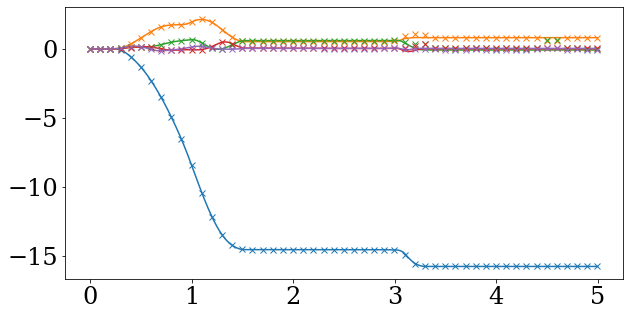

In [21]:
yield_lt_epspepsdiff_epspepsdiff = LinearTreeRegressor(#LinearRegression(fit_intercept=False),
                                    Ridge(alpha=0.1, fit_intercept=False),
                                    criterion='mae',
                                    min_samples_leaf=4*npod_x,
                                    max_depth=npod_eps,
                                    linear_features=range(3*npod_eps),
                                    split_features=range(3*npod_eps))
peps_shift = np.pad(mat2.peps_r[:-1],((1,0),(0,0)),'edge')
x = np.hstack([mat2.epsbar_r, peps_shift, mat2.epsbar_r - peps_shift ])
y = mat2.peps_r
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4,random_state=42,shuffle=False)
yield_lt_epspepsdiff_epspepsdiff.fit(x_train, y_train)
y_trial = yield_lt_epspepsdiff_epspepsdiff.predict(x)
plt.figure(figsize=(10,5))
plt.plot(t,y)
plt.gca().set_prop_cycle(None)
plt.plot(t[::10],y_trial[::10],'x')
yield_lt_epspepsdiff_epspepsdiff.score(x_test,y_test)

-0.058313343342589266

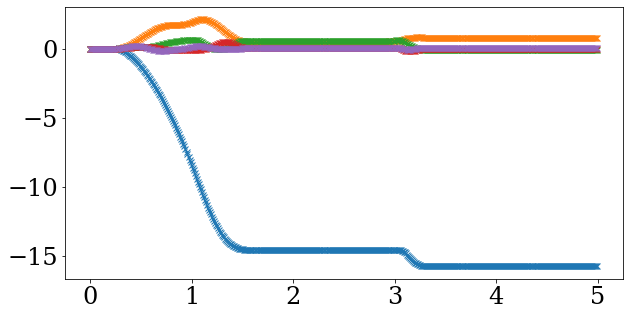

In [22]:
yielddiff_lt_diff_diffpeps = LinearTreeRegressor(#LinearRegression(fit_intercept=False),
                                    Ridge(alpha=0.1, fit_intercept=False),
                                    criterion='mae',
                                    min_samples_leaf=4*npod_x,
                                    max_depth=npod_eps,
                                    linear_features=range(npod_eps),
                                    split_features=range(2*npod_eps))
peps_shift = np.pad(mat2.peps_r[:-1],((1,0),(0,0)),'edge')
eps_shift = np.pad(mat2.epsbar_r[:-1],((1,0),(0,0)),'edge')
diff = mat2.epsbar_r - eps_shift
x = np.hstack([diff, peps_shift])
y = mat2.peps_r - peps_shift
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4,random_state=42,shuffle=False)
yielddiff_lt_diff_diffpeps.fit(x_train, y_train)
y_trial = yielddiff_lt_diff_diffpeps.predict(x)
plt.figure(figsize=(10,5))
plt.plot(t,y+peps_shift)
plt.gca().set_prop_cycle(None)
plt.plot(t[::1],y_trial[::1]+peps_shift[::1],'x')
yielddiff_lt_diff_diffpeps.score(x_test,y_test)

## Force models

In [23]:
def dr_peps_trainfunc_base(mat, stop=501):
    nowpeps = mat.peps_r[:stop]
    oldpeps = np.pad(nowpeps,((1,0),(0,0)),'edge')[:-1]
    x_train = np.hstack([
                mat.xr[:stop] - mat.xr[0],
                nowpeps
            ])
    y_train = mat.fint_r[:stop]
    return x_train, y_train
    
dr_peps_trainfunc = NamedFunc(dr_peps_trainfunc_base,'Reduced displacement augmented with the effective plastic strain')


def dr_peps_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist):

    if i == 0:
        hist.peps_r = mat.peps_r[0]
        hist.epsbar_r = mat.epsbar_r[0]
        hist.peps_r_log = np.zeros_like(mat.peps_r)
        hist.epsbar_r_log = np.zeros_like(mat.epsbar_r)
        hist.fint_r_log = np.zeros_like(mat.fint_r)
    
    try:
        epsbar_r = strain_ridge_x.predict(x.reshape(1,-1)-mat.xr[0]).ravel()
        #epsbar_r = strain_ridge_xeps.predict(np.hstack([x.reshape(1,-1)-mat.xr[0],hist.epsbar_r.reshape(1,-1)])).ravel()
        
        peps_state = np.hstack([epsbar_r, hist.peps_r, epsbar_r-hist.peps_r])
        peps_r = yield_lt_epspeps_epspepsdiff.predict(peps_state.reshape(1,-1)).ravel()

        augmented_state = np.hstack([x.reshape(1,-1)-mat.xr[0], peps_r.reshape(1,-1)])

        hist.peps_r = peps_r
        hist.peps_r_log[i] = peps_r
        hist.epsbar_r = epsbar_r
        hist.epsbar_r_log[i] = epsbar_r

        fint_r_pred = model.predict(augmented_state.reshape(1,-1))

        hist.fint_r_log[i] = fint_r_pred
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\nPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

dr_peps_ar_predfunc = NamedFunc(dr_peps_ar_predfunc_base, 'Prediction from displacement augmented with the effective plastic strain, strain from displacement')

def dr_peps_delay_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist):

    if i == 0:
        hist.peps_r = mat.peps_r[0]
        hist.epsbar_r = mat.epsbar_r[0]
        hist.peps_r_log = np.zeros_like(mat.peps_r)
        hist.epsbar_r_log = np.zeros_like(mat.epsbar_r)
        hist.fint_r_log = np.zeros_like(mat.fint_r)
    
    try:
        #epsbar_r = strain_ridge_x.predict(x.reshape(1,-1)-mat.xr[0]).ravel()
        epsbar_r = strain_ridge_xeps.predict(np.hstack([x.reshape(1,-1)-mat.xr[0],hist.epsbar_r.reshape(1,-1)])).ravel()
        
        peps_state = np.hstack([epsbar_r, hist.peps_r, epsbar_r-hist.peps_r])
        peps_r = yield_lt_epspepsdiff_epspepsdiff.predict(peps_state.reshape(1,-1)).ravel()

        augmented_state = np.hstack([x.reshape(1,-1)-mat.xr[0], peps_r.reshape(1,-1)])

        hist.peps_r = peps_r
        hist.peps_r_log[i] = peps_r
        hist.epsbar_r = epsbar_r
        hist.epsbar_r_log[i] = epsbar_r

        fint_r_pred = model.predict(augmented_state.reshape(1,-1))

        hist.fint_r_log[i] = fint_r_pred
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\nPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

dr_peps_delay_ar_predfunc = NamedFunc(dr_peps_delay_ar_predfunc_base, 'Prediction from displacement augmented with the effective plastic strain, strain from displacement and delay')

def dr_pepsdelta_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist):

    if i == 0:
        hist.peps_r = mat.peps_r[0]
        hist.epsbar_r = mat.epsbar_r[0]
        hist.peps_r_log = np.zeros_like(mat.peps_r)
        hist.epsbar_r_log = np.zeros_like(mat.epsbar_r)
        hist.fint_r_log = np.zeros_like(mat.fint_r)

    try:
        epsbar_r = strain_ridge_x.predict(x.reshape(1,-1)-mat.xr[0]).ravel()
        #epsbar_r = strain_ridge_xeps.predict(np.hstack([x.reshape(1,-1)-mat.xr[0],hist.epsbar_r.reshape(1,-1)])).ravel()
        
        peps_state = np.hstack([epsbar_r - hist.epsbar_r, hist.peps_r])
        peps_r = hist.peps_r + yielddiff_lt_diff_diffpeps.predict(peps_state.reshape(1,-1)).ravel()

        augmented_state = np.hstack([x.reshape(1,-1)-mat.xr[0], peps_r.reshape(1,-1)])

        hist.peps_r = peps_r
        hist.peps_r_log[i] = peps_r
        hist.epsbar_r = epsbar_r
        hist.epsbar_r_log[i] = epsbar_r

        fint_r_pred = model.predict(augmented_state.reshape(1,-1))

        hist.fint_r_log[i] = fint_r_pred
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\nPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

dr_pepsdelta_ar_predfunc = NamedFunc(dr_pepsdelta_ar_predfunc_base, 'Prediction from displacement augmented with the effective plastic strain from delta, strain from displacement')

def dr_pepsdelta_delay_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist):

    if i == 0:
        hist.peps_r = mat.peps_r[0]
        hist.epsbar_r = mat.epsbar_r[0]
        hist.peps_r_log = np.zeros_like(mat.peps_r)
        hist.epsbar_r_log = np.zeros_like(mat.epsbar_r)
        hist.fint_r_log = np.zeros_like(mat.fint_r)

    try:
        #epsbar_r = strain_ridge_x.predict(x.reshape(1,-1)-mat.xr[0]).ravel()
        epsbar_r = strain_ridge_xeps.predict(np.hstack([x.reshape(1,-1)-mat.xr[0],hist.epsbar_r.reshape(1,-1)])).ravel()
        
        peps_state = np.hstack([epsbar_r - hist.epsbar_r, hist.peps_r])
        peps_r = hist.peps_r + yielddiff_lt_diff_diffpeps.predict(peps_state.reshape(1,-1)).ravel()

        augmented_state = np.hstack([x.reshape(1,-1)-mat.xr[0], peps_r.reshape(1,-1)])

        hist.peps_r = peps_r
        hist.peps_r_log[i] = peps_r
        hist.epsbar_r = epsbar_r
        hist.epsbar_r_log[i] = epsbar_r

        fint_r_pred = model.predict(augmented_state.reshape(1,-1))

        hist.fint_r_log[i] = fint_r_pred
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\nPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

dr_pepsdelta_delay_ar_predfunc = NamedFunc(dr_pepsdelta_delay_ar_predfunc_base, 'Prediction from displacement augmented with the effective plastic strain from delta, strain from displacement and delay')

In [24]:
force_ridge_u_peps = make_pipeline(MaxAbsScaler(), Ridge(alpha=0.8))
force_ridge_u_peps2 = make_pipeline(MaxAbsScaler(), Ridge(alpha=0.2))

In [25]:
def dr_pepsoldpepsstep_trainfunc_base(mat, stop=501):
    nowpeps = mat.peps_r[:stop]
    oldpeps = np.pad(nowpeps,((1,0),(0,0)),'edge')[:-1]
    x_train = np.hstack([
                mat.xr[:stop] - mat.xr[0],
                nowpeps, oldpeps, nowpeps - oldpeps
            ])
    y_train = mat.fint_r[:stop]
    return x_train, y_train
    
dr_pepsoldpepsstep_trainfunc = NamedFunc(dr_pepsoldpepsstep_trainfunc_base,'Reduced displacement augmented with the effective plastic strain, its past value and the step between')


def dr_pepsoldpepsstep_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist):

    if i == 0:
        hist.peps_r = mat.peps_r[0]
        hist.epsbar_r = mat.epsbar_r[0]
        hist.peps_r_log = np.zeros_like(mat.peps_r)
        hist.epsbar_r_log = np.zeros_like(mat.epsbar_r)
        hist.fint_r_log = np.zeros_like(mat.fint_r)

    
    try:
        #epsbar_r = strain_ridge_x.predict(x.reshape(1,-1)-mat.xr[0]).ravel()
        epsbar_r = strain_ridge_xeps.predict(np.hstack([x.reshape(1,-1)-mat.xr[0],hist.epsbar_r.reshape(1,-1)])).ravel()
        
        peps_state = np.hstack([epsbar_r, hist.peps_r, epsbar_r-hist.peps_r])
        peps_r = yield_lt_epspeps_epspepsdiff.predict(peps_state.reshape(1,-1)).ravel()

        augment = np.hstack([peps_r, hist.peps_r, peps_r - hist.peps_r])
        augmented_state = np.hstack([x.reshape(1,-1)-mat.xr[0], augment.reshape(1,-1)])

        hist.peps_r = peps_r
        hist.peps_r_log[i] = peps_r
        hist.epsbar_r = epsbar_r
        hist.epsbar_r_log[i] = epsbar_r

        fint_r_pred = model.predict(augmented_state.reshape(1,-1))

        hist.fint_r_log[i] = fint_r_pred
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\nPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

dr_pepsoldpepsstep_ar_predfunc = NamedFunc(dr_pepsoldpepsstep_ar_predfunc_base,'Reduced displacement augmented with the effective plastic strain, its past value and the step between')


def dr_pepsoldpepsstep2_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist):

    if i == 0:
        hist.peps_r = mat.peps_r[0]
        hist.epsbar_r = mat.epsbar_r[0]
        hist.peps_r_log = np.zeros_like(mat.peps_r)
        hist.epsbar_r_log = np.zeros_like(mat.epsbar_r)
        hist.fint_r_log = np.zeros_like(mat.fint_r)
    
    try:
        #epsbar_r = strain_ridge_x.predict(x.reshape(1,-1)-mat.xr[0]).ravel()
        epsbar_r = strain_ridge_xeps.predict(np.hstack([x.reshape(1,-1)-mat.xr[0],hist.epsbar_r.reshape(1,-1)])).ravel()
        
        peps_state = np.hstack([epsbar_r - hist.epsbar_r, hist.peps_r])
        peps_r = hist.peps_r + yielddiff_lt_diff_diffpeps.predict(peps_state.reshape(1,-1)).ravel()

        augment = np.hstack([peps_r, hist.peps_r, peps_r - hist.peps_r])
        augmented_state = np.hstack([x.reshape(1,-1)-mat.xr[0], augment.reshape(1,-1)])

        hist.peps_r = peps_r
        hist.peps_r_log[i] = peps_r
        hist.epsbar_r = epsbar_r
        hist.epsbar_r_log[i] = epsbar_r

        fint_r_pred = model.predict(augmented_state.reshape(1,-1))

        hist.fint_r_log[i] = fint_r_pred
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\nPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

dr_pepsoldpepsstep2_ar_predfunc = NamedFunc(dr_pepsoldpepsstep2_ar_predfunc_base,'Reduced displacement augmented with the effective plastic strain, its past value and the step between')


In [26]:
force_lt_u_all = LinearTreeRegressor(
                                    Ridge(alpha=0.2, fit_intercept=False),
                                    criterion='mae',
                                    min_samples_leaf=4*npod_x,
                                    max_depth=npod_eps,
                                    linear_features=range(npod_x))

force_ltsym_u_all = LinearTreeRegressor(
                                    SymmetricRidge(alpha=0.5),
                                    criterion='mae',
                                    min_samples_leaf=4*npod_x,
                                    max_depth=npod_eps,
                                    linear_features=range(npod_x))

force_lt_u_pepsoldpepsstep = LinearTreeRegressor(
                                    Ridge(alpha=0.2, fit_intercept=False),
                                    criterion='mae',
                                    min_samples_leaf=4*npod_x,
                                    max_depth=npod_eps,
                                    linear_features=range(npod_x),
                                    split_features=range(npod_x,npod_x+3*npod_eps))

force_ltsym_u_pepsoldpepsstep = LinearTreeRegressor(
                                    SymmetricRidge(alpha=0.5),
                                    criterion='mae',
                                    min_samples_leaf=4*npod_x,
                                    max_depth=npod_eps,
                                    linear_features=range(npod_x),
                                    split_features=range(npod_x,npod_x+3*npod_eps))

force_lt_all_all = LinearTreeRegressor(
                                    Ridge(alpha=0.2, fit_intercept=False),
                                    criterion='mae',
                                    min_samples_leaf=4*npod_x,
                                    max_depth=npod_eps)

## Evaluation

### Non-ensemble

In [13]:
def drpeps_drpeps_trainfunc_base(mat, stop=501):
    stop -= 1
    nowpeps = mat.peps_r[:stop]
    x_train = np.hstack([
                mat.xr[:stop] - mat.xr[0],
                nowpeps
            ])
    y_train = np.hstack([mat.fint_r[:stop],mat.peps_r[1:stop+1]])
    if stop==500:
        return np.pad(x_train,((0,1),(0,0)),'edge'),np.pad(y_train,((0,1),(0,0)),'edge')
    return x_train, y_train
    
drpeps_drpeps_trainfunc = NamedFunc(drpeps_drpeps_trainfunc_base,'Reduced displacement augmented with the current effective plastic strain for regression')

def drpeps_droldpeps_trainfunc_base(mat, stop=501):
    nowpeps = mat.peps_r[:stop]
    oldpeps = np.pad(nowpeps,((1,0),(0,0)),'edge')[:-1]
    x_train = np.hstack([
                mat.xr[:stop] - mat.xr[0],
                oldpeps
            ])
    y_train = np.hstack([mat.fint_r[:stop],nowpeps])
    return x_train, y_train
    
drpeps_droldpeps_trainfunc = NamedFunc(drpeps_droldpeps_trainfunc_base,'Reduced displacement augmented with the previous effective plastic strain for regression')


def drpeps_drpeps_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist):

    if i == 0:
        hist.peps_r = mat.peps_r[0]
        hist.peps_r_log = np.zeros_like(mat.peps_r)
    
    try:
        augmented_state = np.hstack([x.reshape(1,-1)-mat.xr[0], hist.peps_r.reshape(1,-1)])
        augmented_output = model.predict(augmented_state.reshape(1,-1))

        fint_r_pred = augmented_output[:,:x.shape[1]]
        peps_r = augmented_output[:,x.shape[1]:]

        hist.peps_r = peps_r
        hist.peps_r_log[i] = peps_r
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\nPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

drpeps_drpeps_ar_predfunc = NamedFunc(drpeps_drpeps_ar_predfunc_base, 'Prediction from displacement augmented with the effective plastic strain all-in-one')

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=0.0))])(Reduced displacement augmented with the previous effective plastic strain for regression, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain all-in-one
	POD components:	4
	Training range:	0:300/501


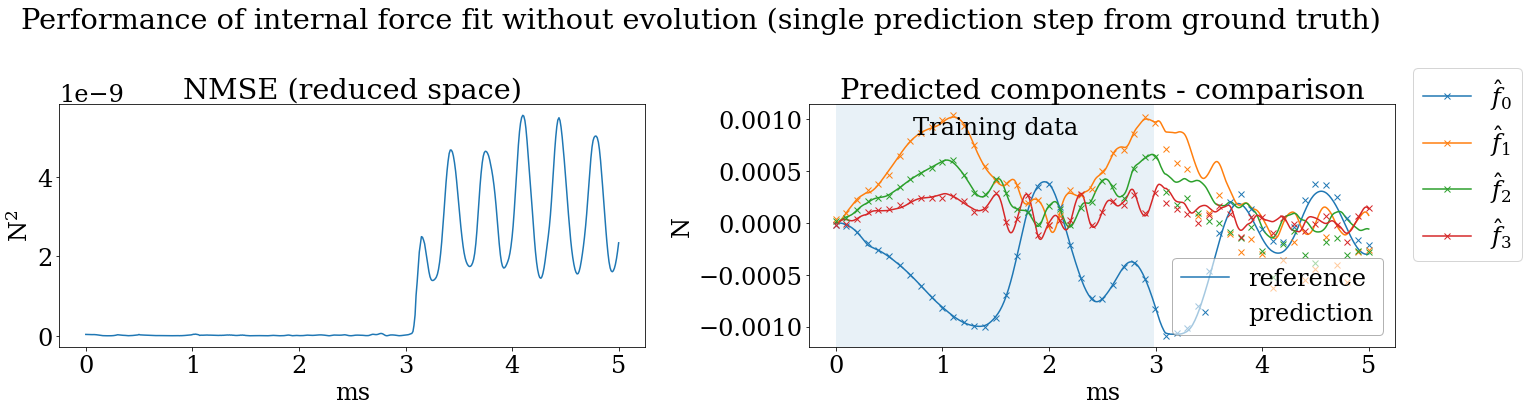

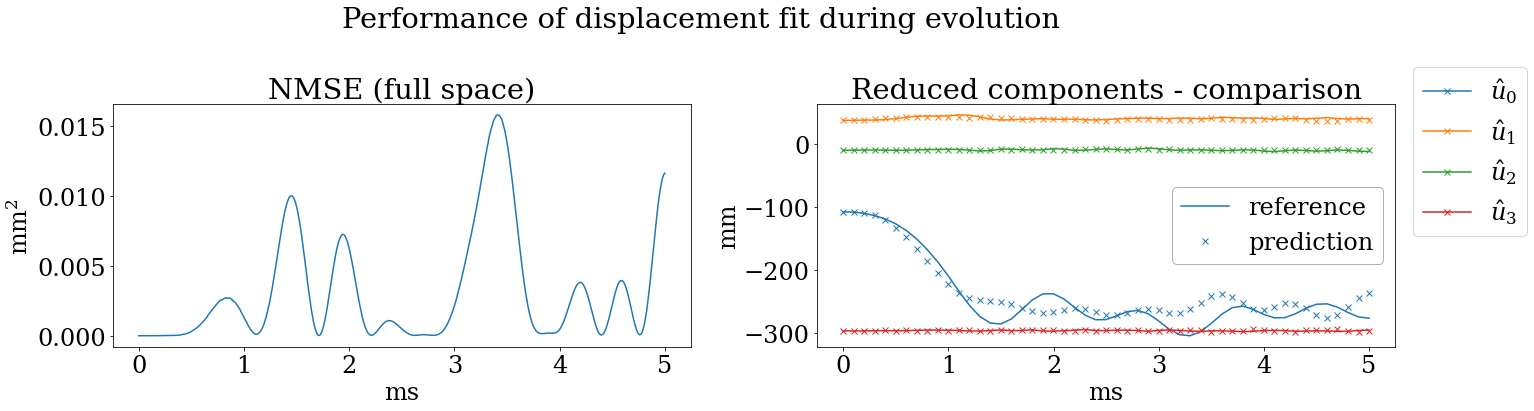

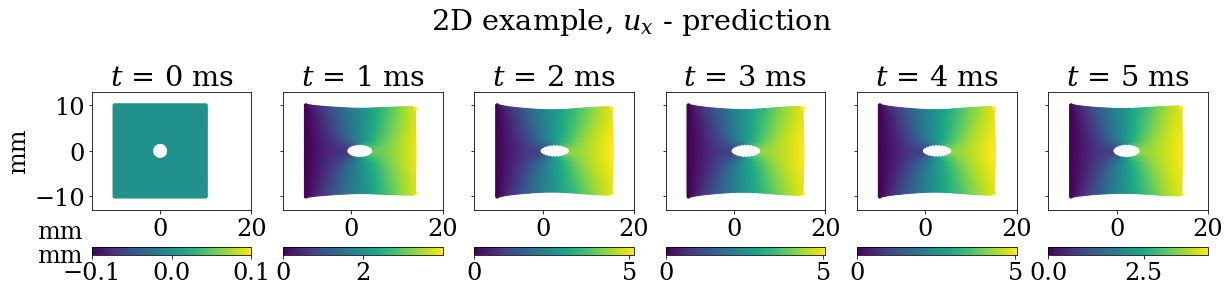

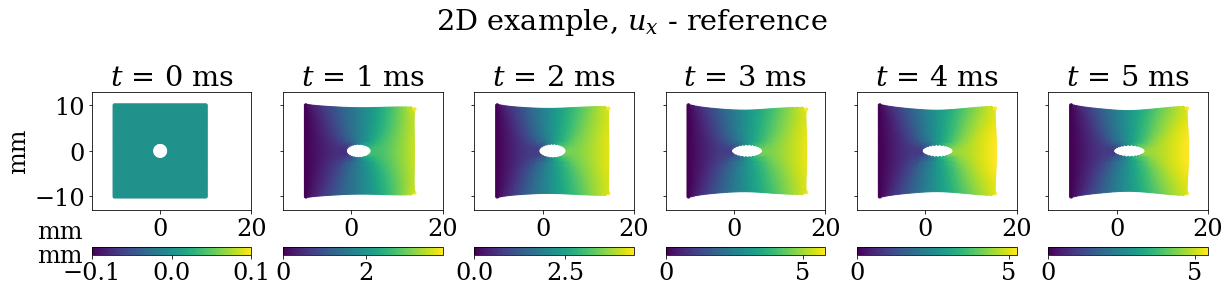

In [14]:
out = evaluate2D(mat2,make_pipeline(MaxAbsScaler(),Ridge(alpha=0.)),drpeps_droldpeps_trainfunc, drpeps_droldpeps_trainfunc, drpeps_drpeps_ar_predfunc,4,training_stop=300,eps_basis_size=npod_eps)

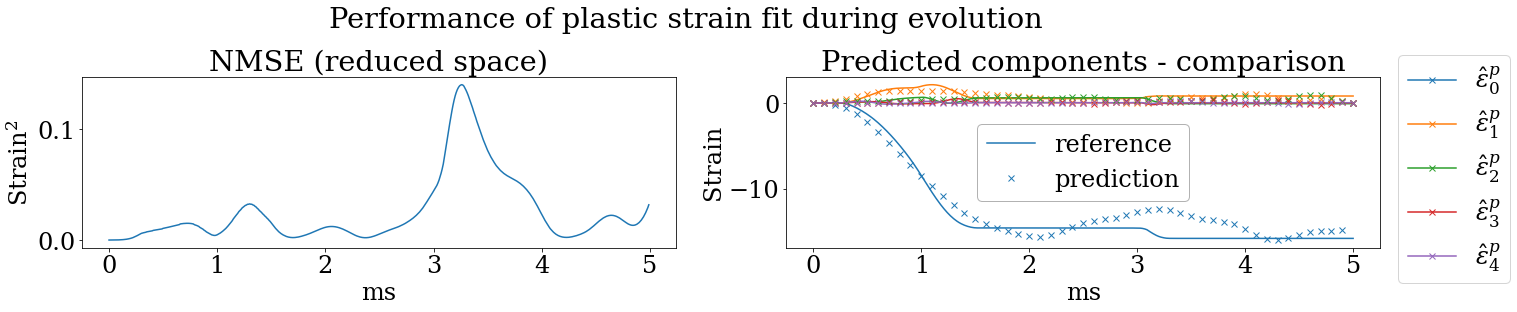

In [16]:
peps_test = out['hist'].peps_r_log
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(t[:-1], (((peps_test-mat2.peps_r)**2).mean(axis=1)/(peps_test.max()-peps_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.peps_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(t[::10],peps_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}^p_{{{i}}}$") for i in range(mat2.peps_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of plastic strain fit during evolution',y=0.9)
plt.tight_layout();

'Saved to ../animations/plastic_peps_4pods.gif'

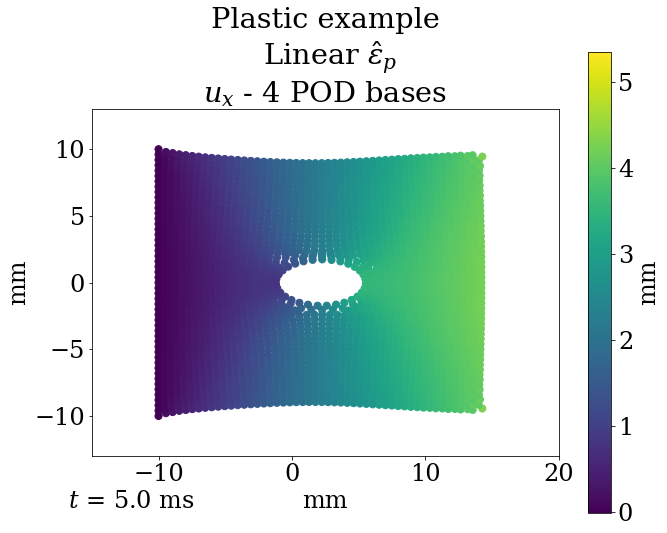

In [17]:
xroutinv = out['xroutinv']
dx_xroutinv = (xroutinv - xroutinv[0])[:,:xroutinv.shape[1]//2]
xx_xroutinv = mat2.xx[0] + xroutinv - xroutinv[0]
animatedplot2D(dx_xroutinv, xx_xroutinv[:,:xx_xroutinv.shape[1]//2],xx_xroutinv[:,xx_xroutinv.shape[1]//2:],
                path = "../animations/plastic_peps_4pods",
                title = "Plastic example\n Linear " r"$\hat{\varepsilon}_p$" "\n" r"$u_x$ - 4 POD bases",
               total_frames=100)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	LinearTreeRegressor(base_estimator=Ridge(alpha=1), criterion='mae',
                    min_samples_leaf=16, split_features=range(0, 9))(Reduced displacement augmented with the current effective plastic strain for regression, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain all-in-one
	POD components:	4
	Training range:	0:300/501


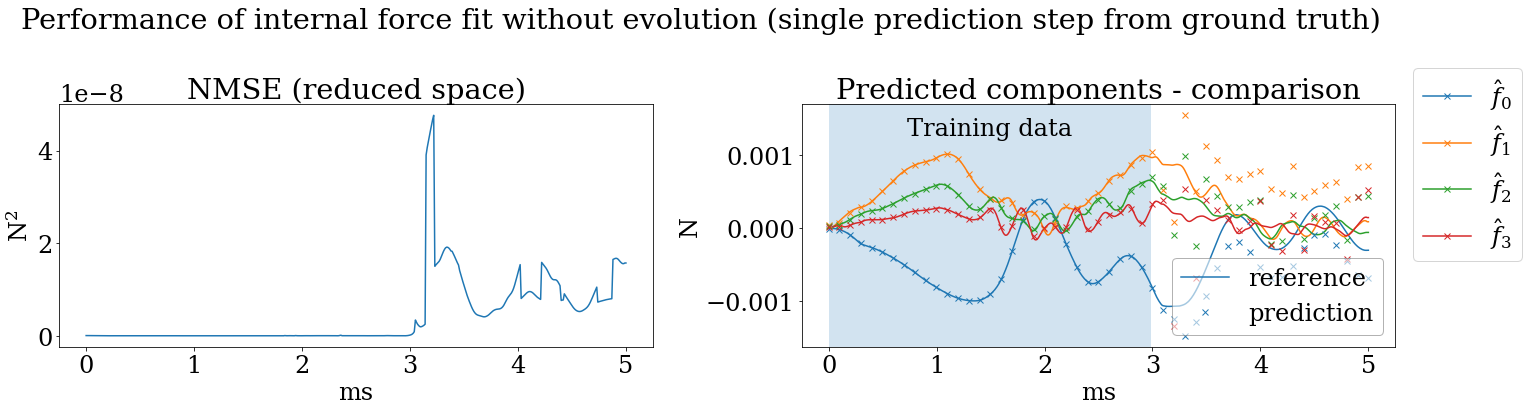

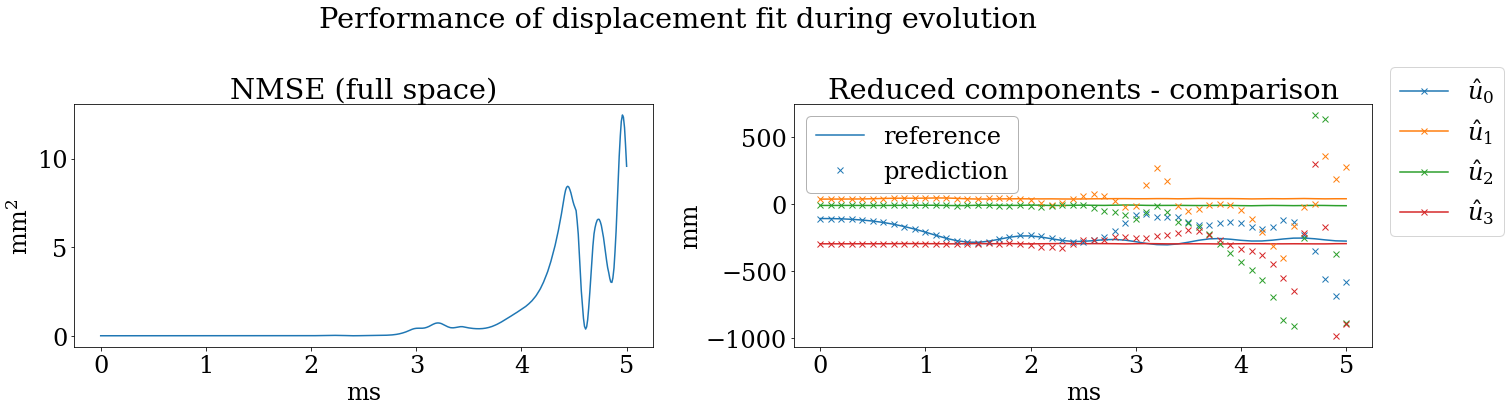

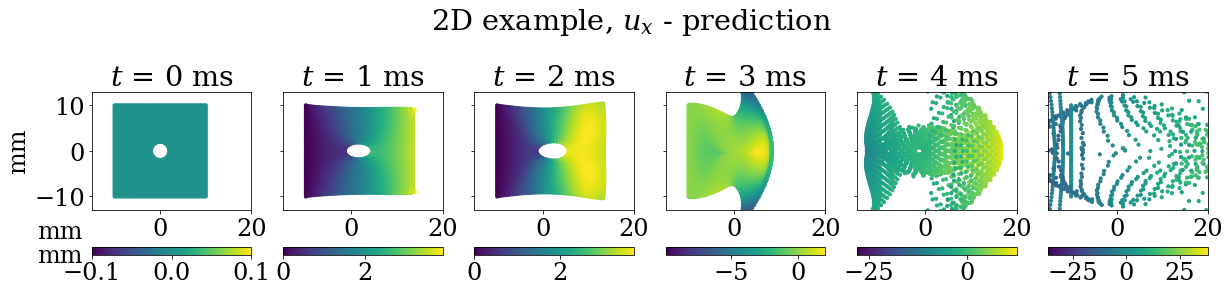

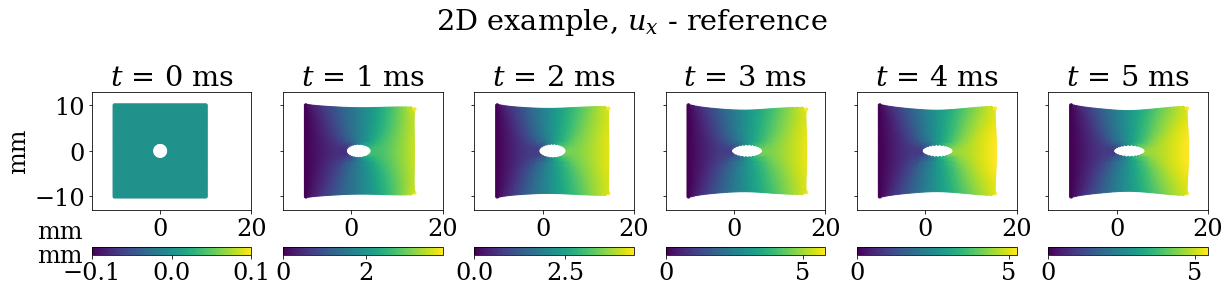

In [35]:
out = evaluate2D(mat2,LinearTreeRegressor(Ridge(alpha=1),criterion='mae',min_samples_leaf=4*npod_x,max_depth=npod_eps,split_features=range(0,npod_x+npod_eps)),
                drpeps_drpeps_trainfunc, drpeps_drpeps_trainfunc, drpeps_drpeps_ar_predfunc,4,training_stop=300,eps_basis_size=npod_eps)

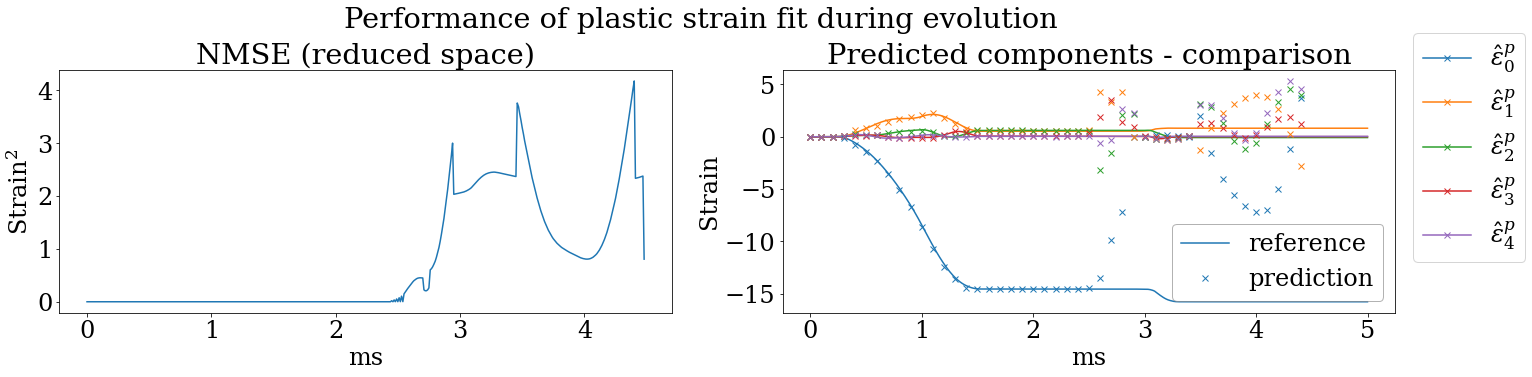

In [31]:
peps_test = out['hist'].peps_r_log[:450]
tt = t[:peps_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((peps_test-mat2.peps_r[:peps_test.shape[0]])**2).mean(axis=1)/(peps_test.max()-peps_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.peps_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],peps_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}^p_{{{i}}}$") for i in range(mat2.peps_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of plastic strain fit during evolution',y=0.9)
plt.tight_layout();

### Regressive force models

Linear tree yield difference
* $f^{n}=\mathcal{F}(\hat{x}^n,\hat{\varepsilon}_p^n)$
* $\hat{\varepsilon}^n = \mathcal{\bar{E}}(\hat{x}^n,\hat{\varepsilon}^{n-1})$
* $\hat{\varepsilon}_p^n = \hat{\varepsilon}_p^{n-1} + \mathcal{E_p^{\Delta}}(\hat{\varepsilon}^n-\hat{\varepsilon}^{n-1})[(\hat{\varepsilon}^n-\hat{\varepsilon}^{n-1}),\hat{\varepsilon}_p^{n-1}]$

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=0.2))])(Reduced displacement augmented with the effective plastic strain, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain from delta, strain from displacement and delay
	POD components:	4
	Training range:	0:300/501


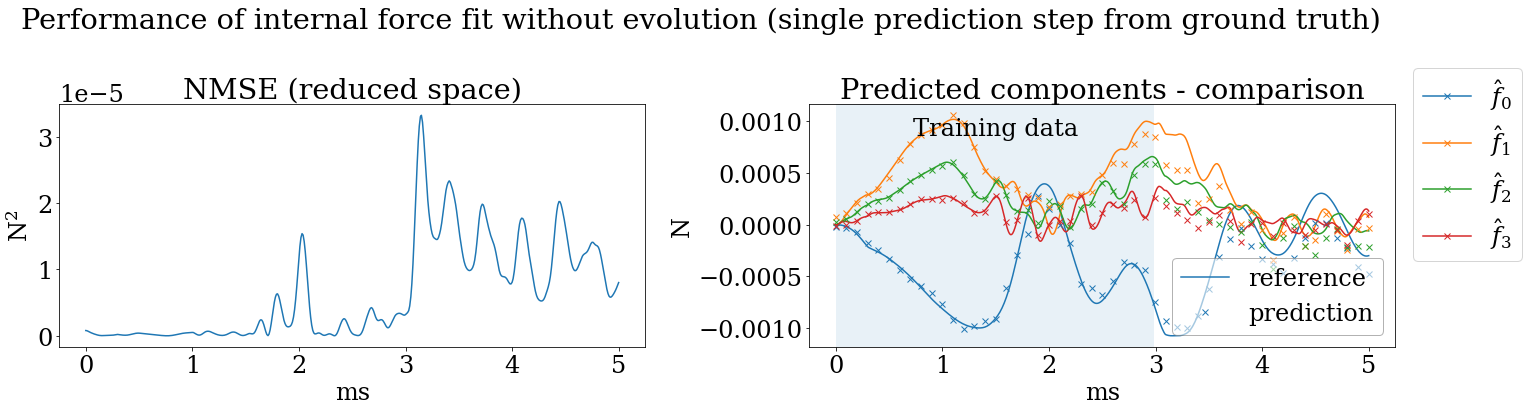

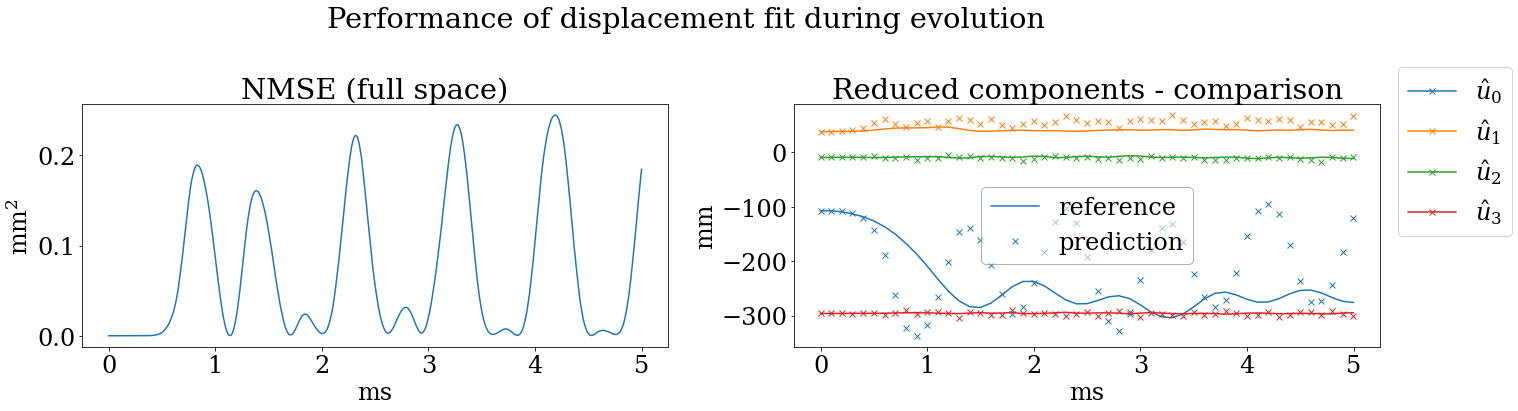

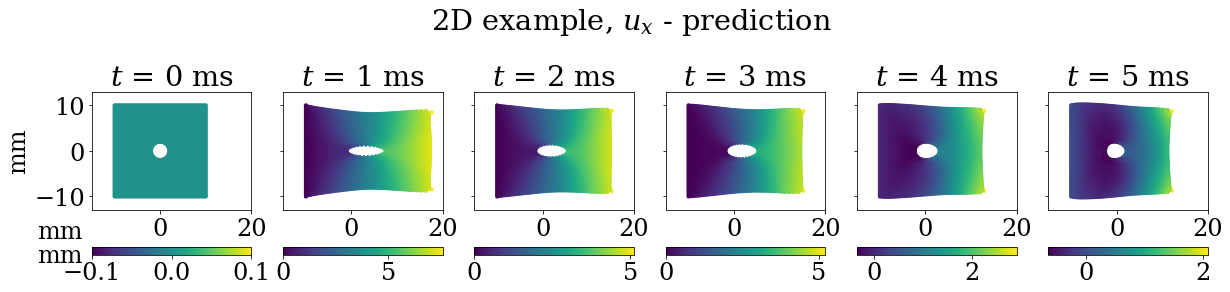

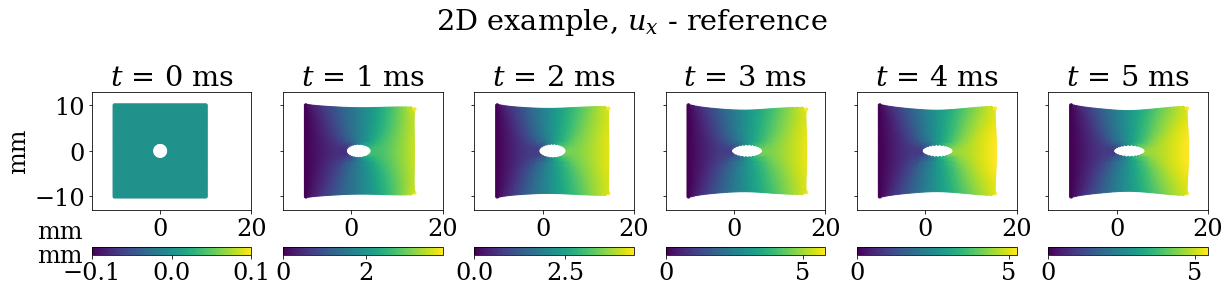

In [88]:
out = evaluate2D(mat2,force_ridge_u_peps2,dr_peps_trainfunc, dr_peps_trainfunc, dr_pepsdelta_delay_ar_predfunc,4,training_stop=300,eps_basis_size=npod_eps)

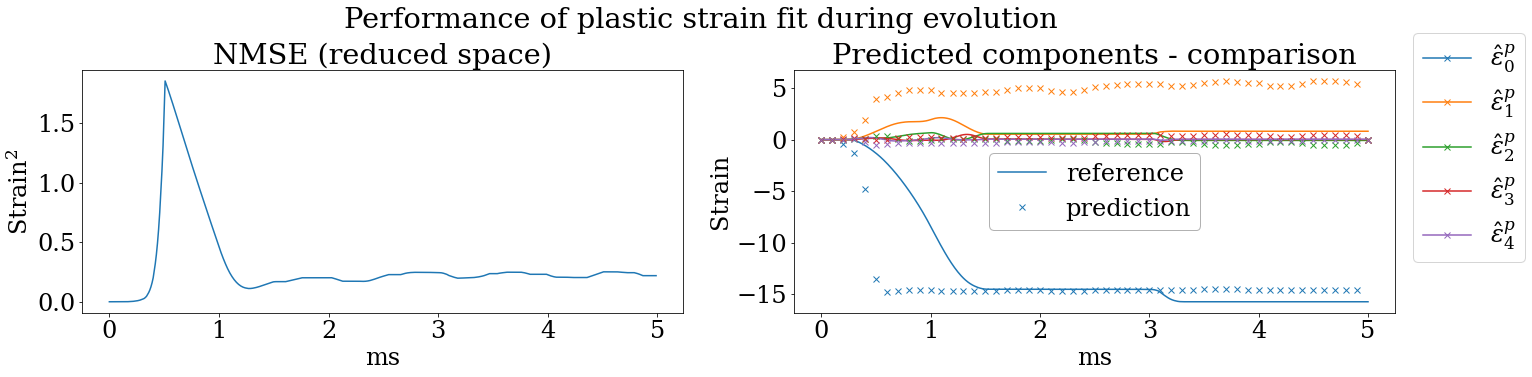

In [89]:
peps_test = out['hist'].peps_r_log[:]
tt = t[:peps_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((peps_test-mat2.peps_r[:peps_test.shape[0]])**2).mean(axis=1)/(peps_test.max()-peps_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.peps_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],peps_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}^p_{{{i}}}$") for i in range(mat2.peps_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of plastic strain fit during evolution',y=0.9)
plt.tight_layout();

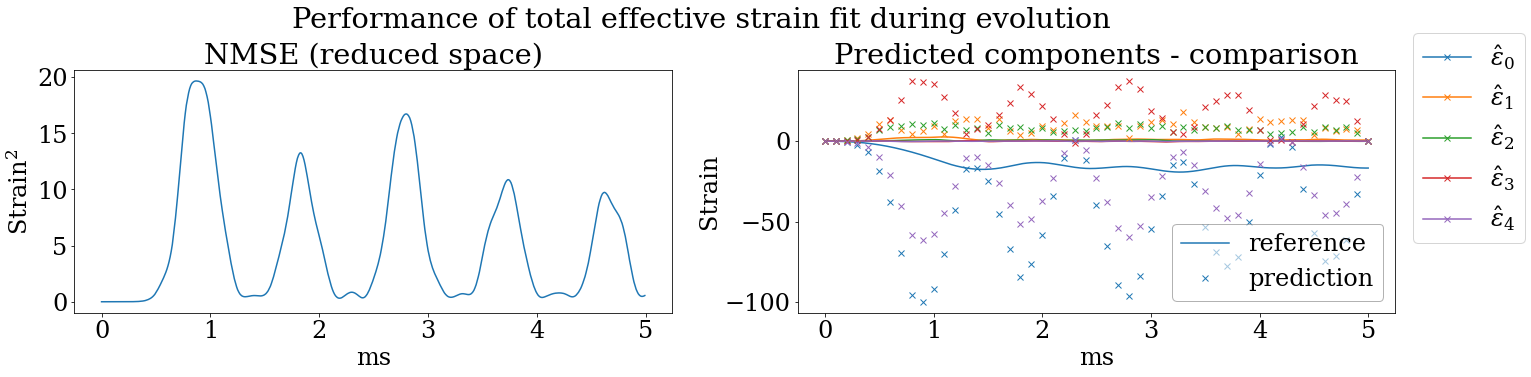

In [90]:
epsbar_test = out['hist'].epsbar_r_log[:]
tt = t[:epsbar_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((epsbar_test-mat2.epsbar_r[:epsbar_test.shape[0]])**2).mean(axis=1)/(epsbar_test.max()-epsbar_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.epsbar_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],epsbar_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}_{{{i}}}$") for i in range(mat2.epsbar_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of total effective strain fit during evolution',y=0.9)
plt.tight_layout();

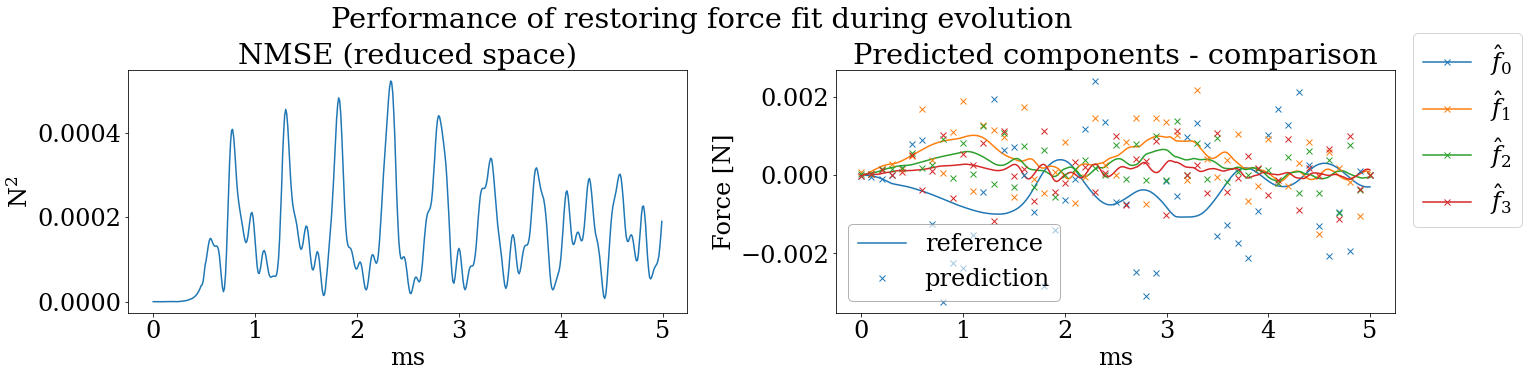

In [91]:
fint_test = out['hist'].fint_r_log[:]
tt = t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit during evolution',y=0.9)
plt.tight_layout();

Linear tree yield
* $f^{n}=\mathcal{F}(\hat{x}^n,\hat{\varepsilon}_p^n)$
* $\hat{\varepsilon}^n = \mathcal{\bar{E}}(\hat{x}^n)$
* $\hat{\varepsilon}_p^n = \mathcal{E_p}(\hat{\varepsilon}^n,\hat{\varepsilon}_p^{n-1})[\hat{\varepsilon}^n,\hat{\varepsilon}_p^{n-1},(\hat{\varepsilon}^n-\hat{\varepsilon}_p^{n-1})]$

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=0.8))])(Reduced displacement augmented with the effective plastic strain, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain, strain from displacement
	POD components:	4
	Training range:	0:300/501


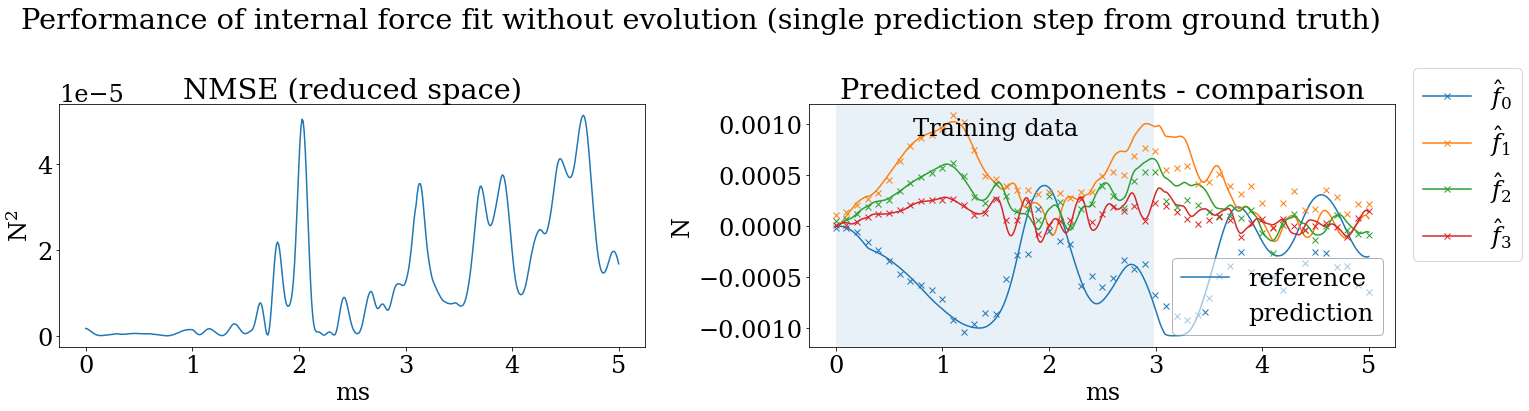

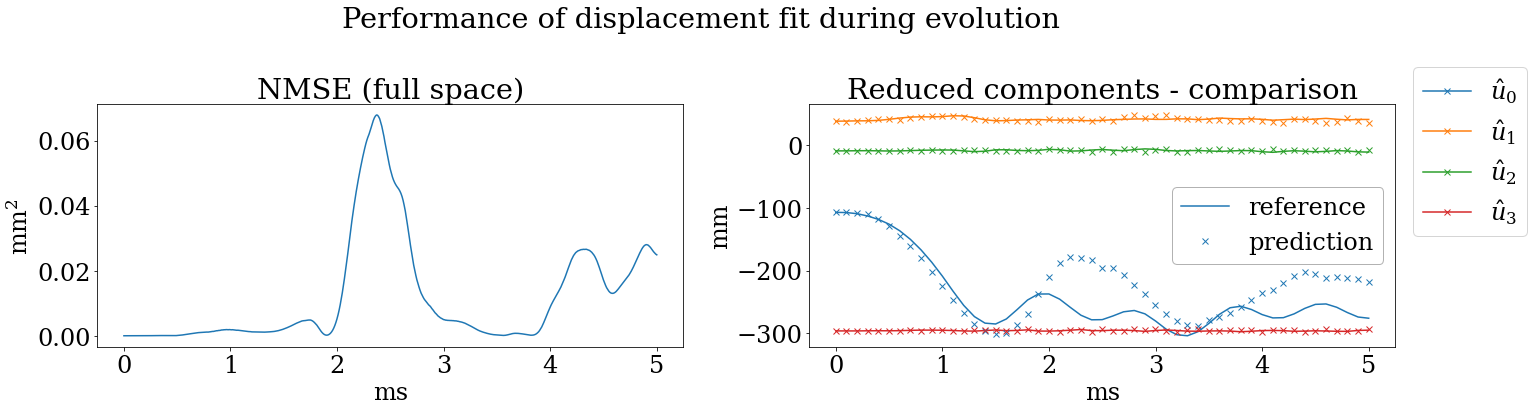

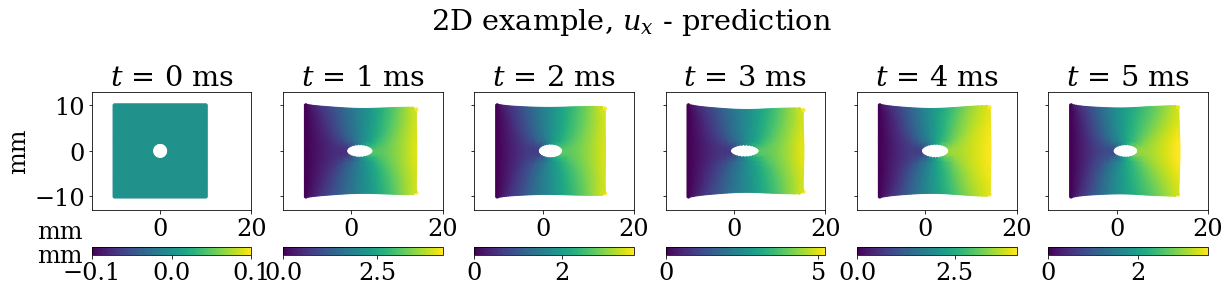

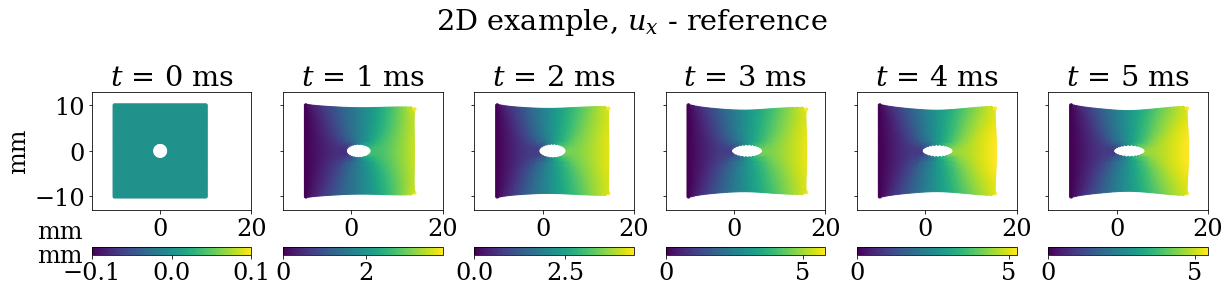

In [27]:
out = evaluate2D(mat2,force_ridge_u_peps,dr_peps_trainfunc, dr_peps_trainfunc, dr_peps_ar_predfunc,4,training_stop=300,eps_basis_size=npod_eps)

'Saved to ../animations/plastic_ltree_4pods.gif'

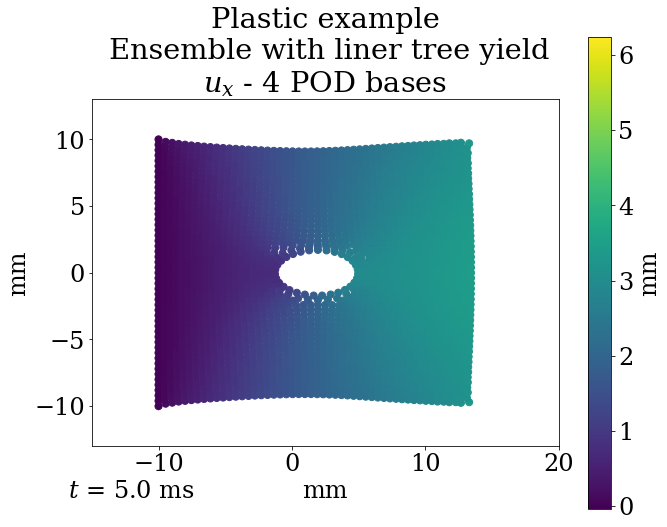

In [29]:
xroutinv = out['xroutinv']
dx_xroutinv = (xroutinv - xroutinv[0])[:,:xroutinv.shape[1]//2]
xx_xroutinv = mat2.xx[0] + xroutinv - xroutinv[0]
animatedplot2D(dx_xroutinv, xx_xroutinv[:,:xx_xroutinv.shape[1]//2],xx_xroutinv[:,xx_xroutinv.shape[1]//2:],
                path = "../animations/plastic_ltree_4pods",
                title = "Plastic example\n Ensemble with liner tree yield\n" r"$u_x$ - 4 POD bases",
               total_frames=100)

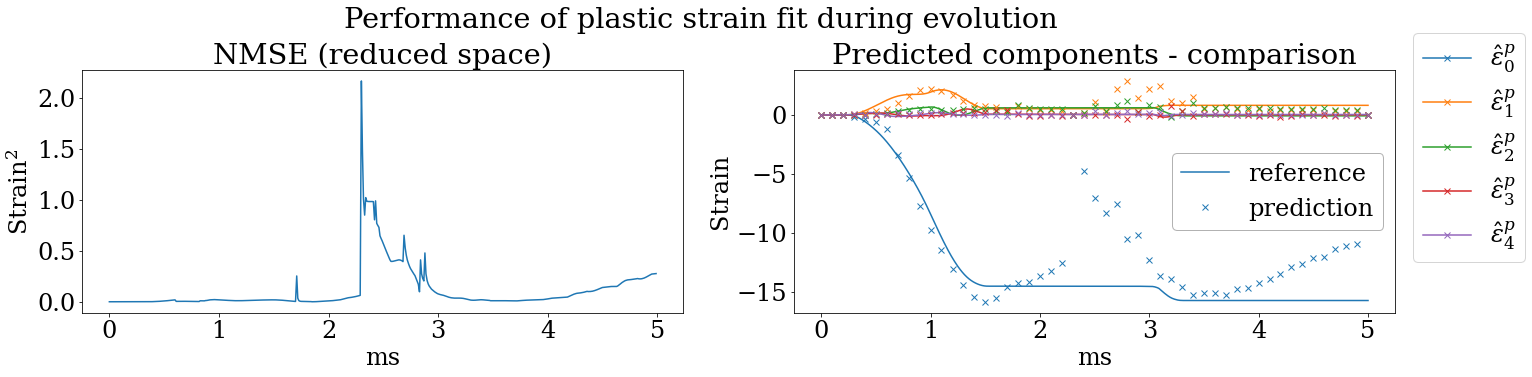

In [96]:
peps_test = out['hist'].peps_r_log[:]
tt = t[:peps_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((peps_test-mat2.peps_r[:peps_test.shape[0]])**2).mean(axis=1)/(peps_test.max()-peps_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.peps_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],peps_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}^p_{{{i}}}$") for i in range(mat2.peps_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of plastic strain fit during evolution',y=0.9)
plt.tight_layout();

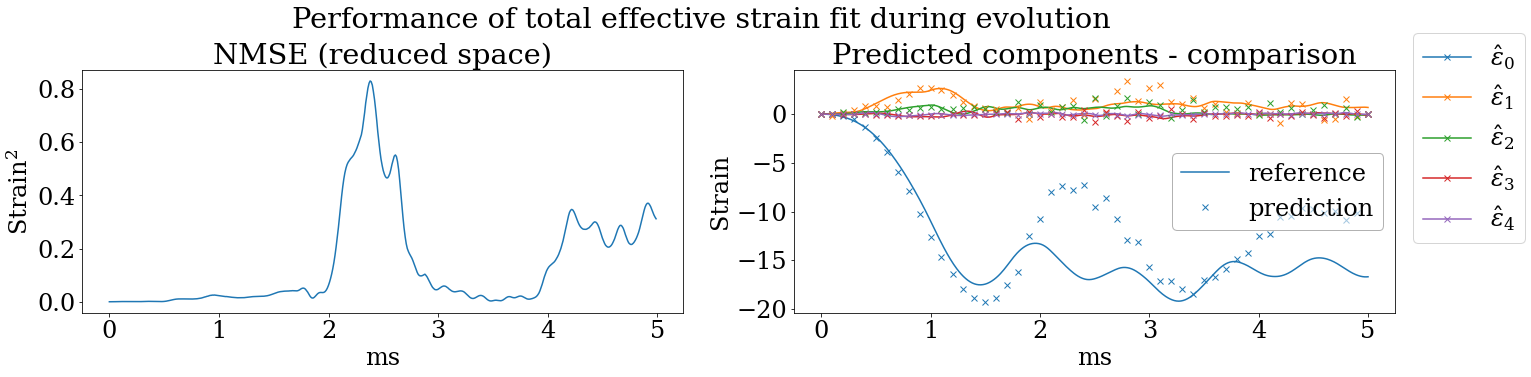

In [97]:
epsbar_test = out['hist'].epsbar_r_log[:]
tt = t[:epsbar_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((epsbar_test-mat2.epsbar_r[:epsbar_test.shape[0]])**2).mean(axis=1)/(epsbar_test.max()-epsbar_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.epsbar_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],epsbar_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}_{{{i}}}$") for i in range(mat2.epsbar_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of total effective strain fit during evolution',y=0.9)
plt.tight_layout();

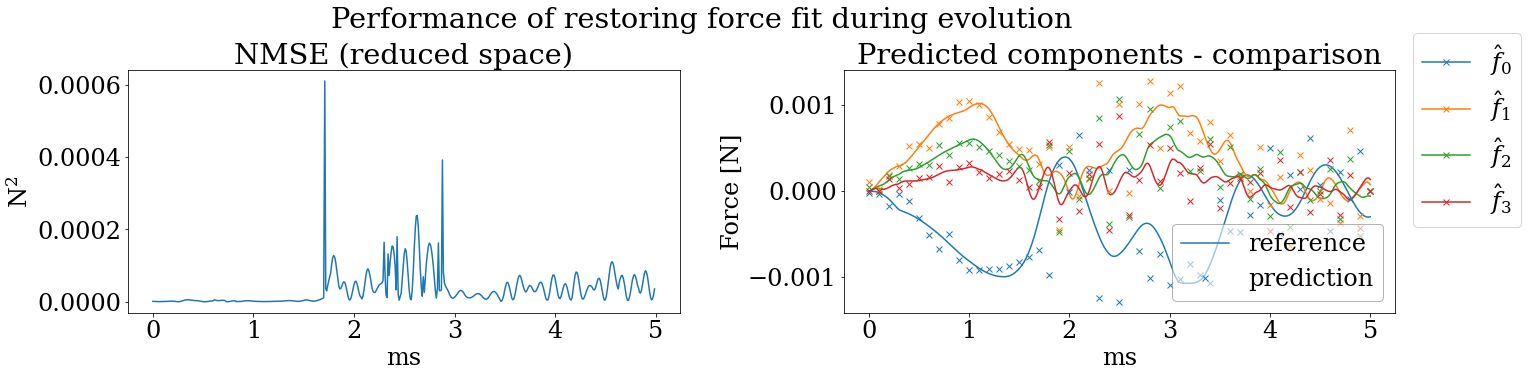

In [98]:
fint_test = out['hist'].fint_r_log[:]
tt = t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit during evolution',y=0.9)
plt.tight_layout();

### Linear tree force models

Linear tree yield difference
* $f^{n}=\mathcal{F}(\hat{x}^n)[\hat{\varepsilon}_p^n,\hat{\varepsilon}_p^{n-1},(\hat{\varepsilon}_p^n-\hat{\varepsilon}_p^{n-1})]$
* $\hat{\varepsilon}^n = \mathcal{\bar{E}}(\hat{x}^n,\hat{\varepsilon}^{n-1})$
* $\hat{\varepsilon}_p^n = \hat{\varepsilon}_p^n + \mathcal{E_p^{\Delta}}(\hat{\varepsilon}^n-\hat{\varepsilon}^{n-1})[(\hat{\varepsilon}^n-\hat{\varepsilon}^{n-1}),\hat{\varepsilon}_p^{n-1}]$

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	LinearTreeRegressor(base_estimator=SymmetricRidge(alpha=0.5), criterion='mae',
                    linear_features=range(0, 4), min_samples_leaf=16,
                    split_features=range(4, 19))(Reduced displacement augmented with the effective plastic strain, its past value and the step between, Reduced Internal force)
	Acceleration function:	Reduced displacement augmented with the effective plastic strain, its past value and the step between
	POD components:	4
	Training range:	0:300/501


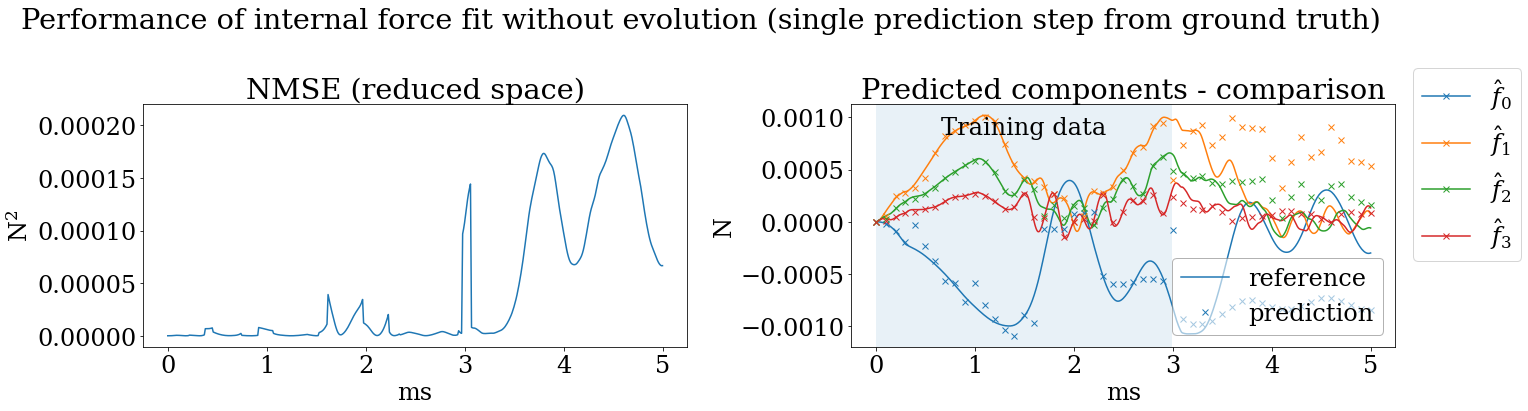

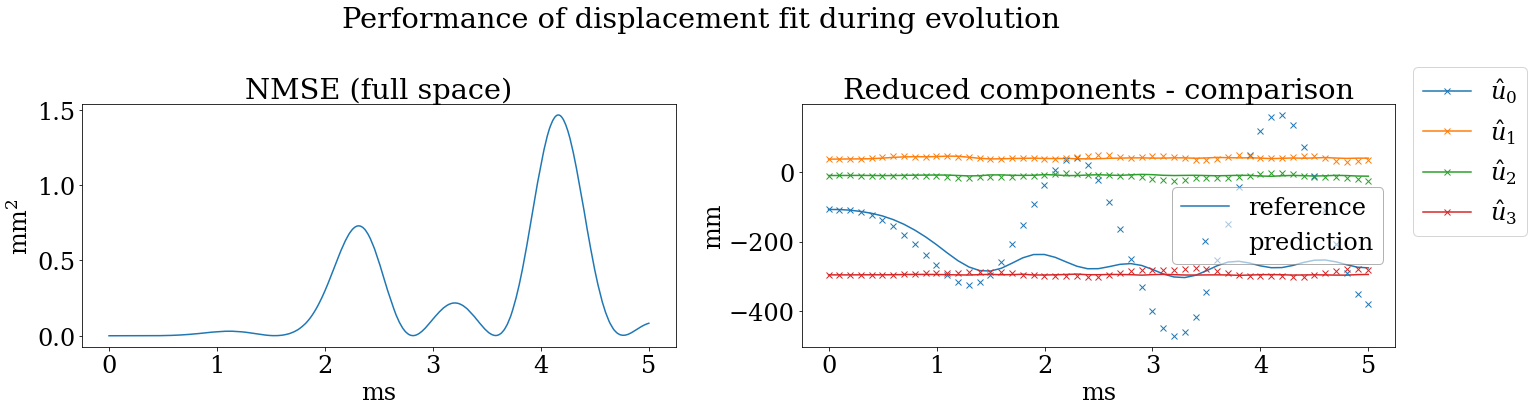

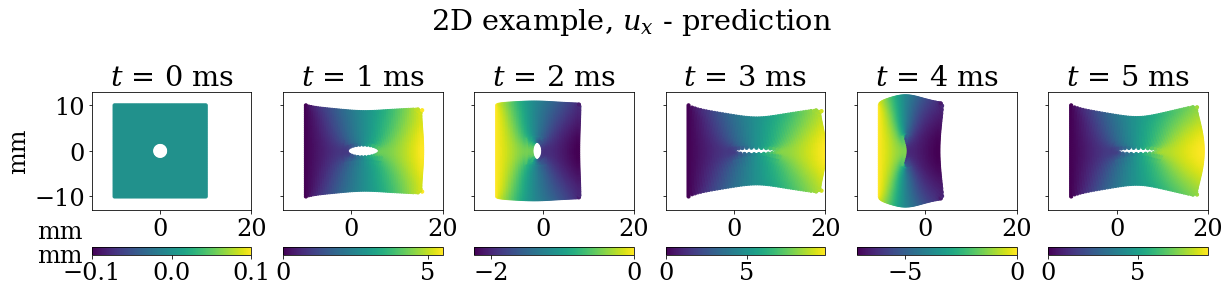

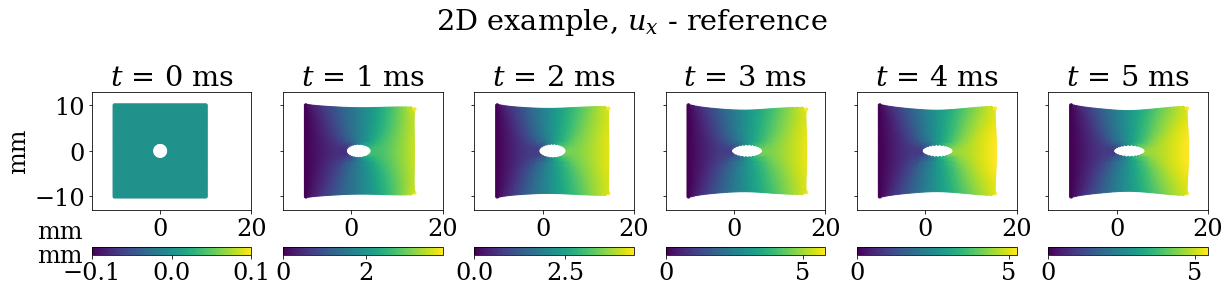

In [131]:
out = evaluate2D(mat2,force_ltsym_u_pepsoldpepsstep,dr_pepsoldpepsstep_trainfunc, dr_pepsoldpepsstep_trainfunc, dr_pepsoldpepsstep2_ar_predfunc,4,training_stop=300,eps_basis_size=npod_eps)

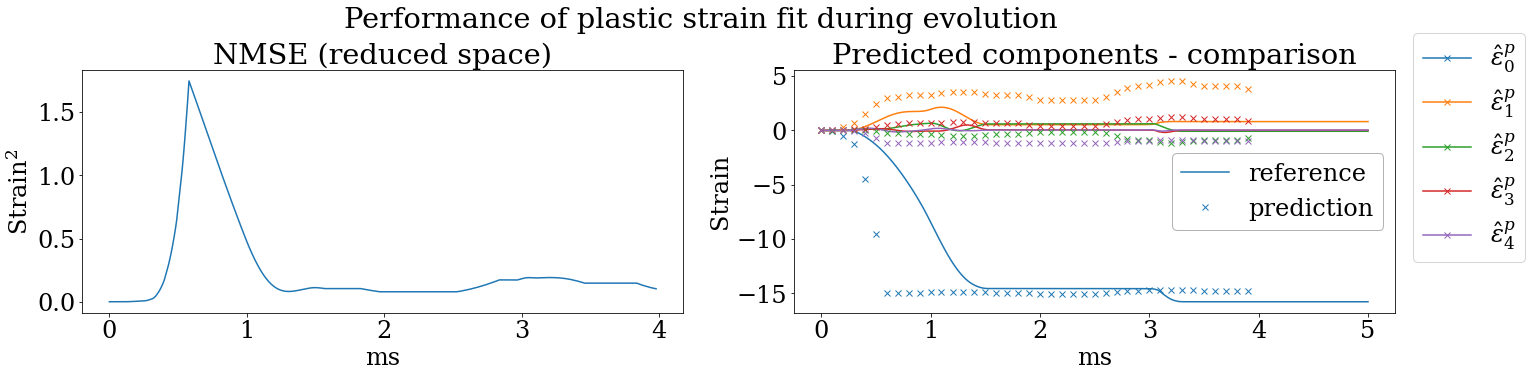

In [132]:
peps_test = out['hist'].peps_r_log[:400]
tt = t[:peps_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((peps_test-mat2.peps_r[:peps_test.shape[0]])**2).mean(axis=1)/(peps_test.max()-peps_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.peps_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],peps_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}^p_{{{i}}}$") for i in range(mat2.peps_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of plastic strain fit during evolution',y=0.9)
plt.tight_layout();

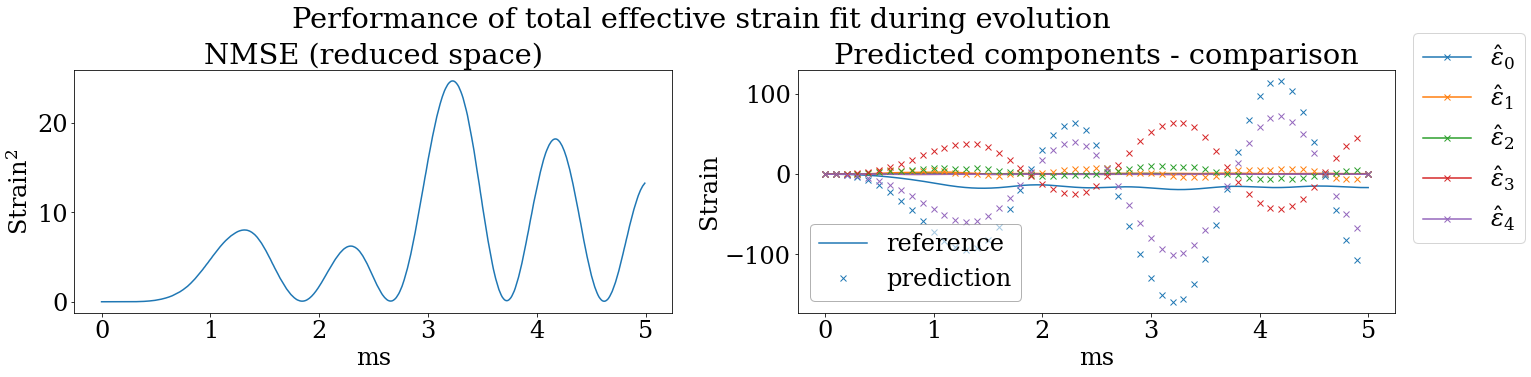

In [133]:
epsbar_test = out['hist'].epsbar_r_log[:]
tt = t[:epsbar_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((epsbar_test-mat2.epsbar_r[:epsbar_test.shape[0]])**2).mean(axis=1)/(epsbar_test.max()-epsbar_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.epsbar_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],epsbar_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}_{{{i}}}$") for i in range(mat2.epsbar_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of total effective strain fit during evolution',y=0.9)
plt.tight_layout();

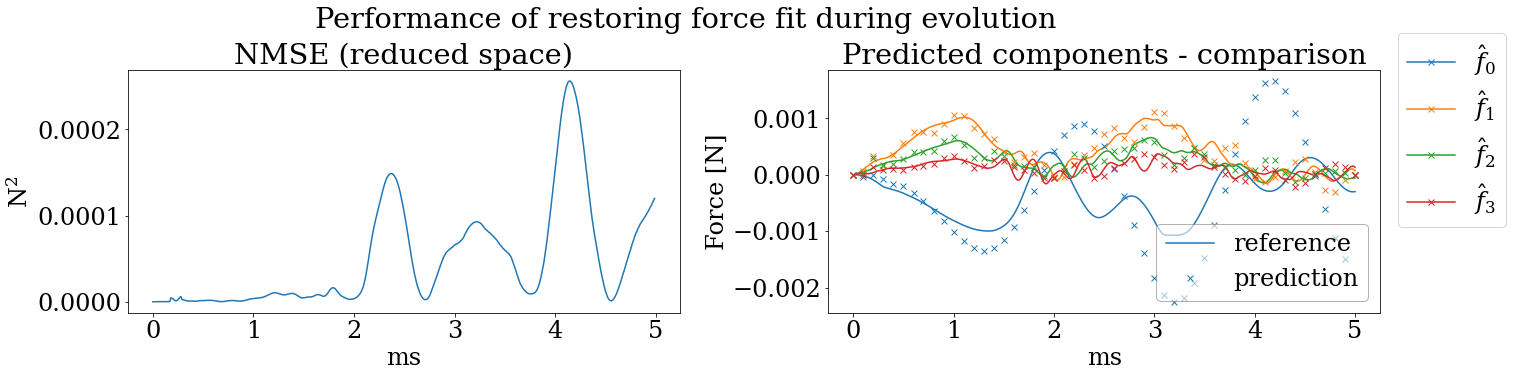

In [134]:
fint_test = out['hist'].fint_r_log[:]
tt = t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit during evolution',y=0.9)
plt.tight_layout();

Linear tree yield
* $f^{n}=\mathcal{F}(\hat{x}^n)[\hat{\varepsilon}_p^n,\hat{\varepsilon}_p^{n-1},(\hat{\varepsilon}_p^n-\hat{\varepsilon}_p^{n-1})]$
* $\hat{\varepsilon}^n = \mathcal{\bar{E}}(\hat{x}^n,\hat{\varepsilon}^{n-1})$
* $\hat{\varepsilon}_p^n = \mathcal{E_p}(\hat{\varepsilon}^n,\hat{\varepsilon}_p^{n-1})[\hat{\varepsilon}^n,\hat{\varepsilon}_p^{n-1},(\hat{\varepsilon}^n-\hat{\varepsilon}_p^{n-1})]$

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	LinearTreeRegressor(base_estimator=Ridge(alpha=0.2, fit_intercept=False),
                    criterion='mae', linear_features=range(0, 4),
                    min_samples_leaf=16, split_features=range(4, 19))(Reduced displacement augmented with the effective plastic strain, its past value and the step between, Reduced Internal force)
	Acceleration function:	Reduced displacement augmented with the effective plastic strain, its past value and the step between
	POD components:	4
	Training range:	0:300/501


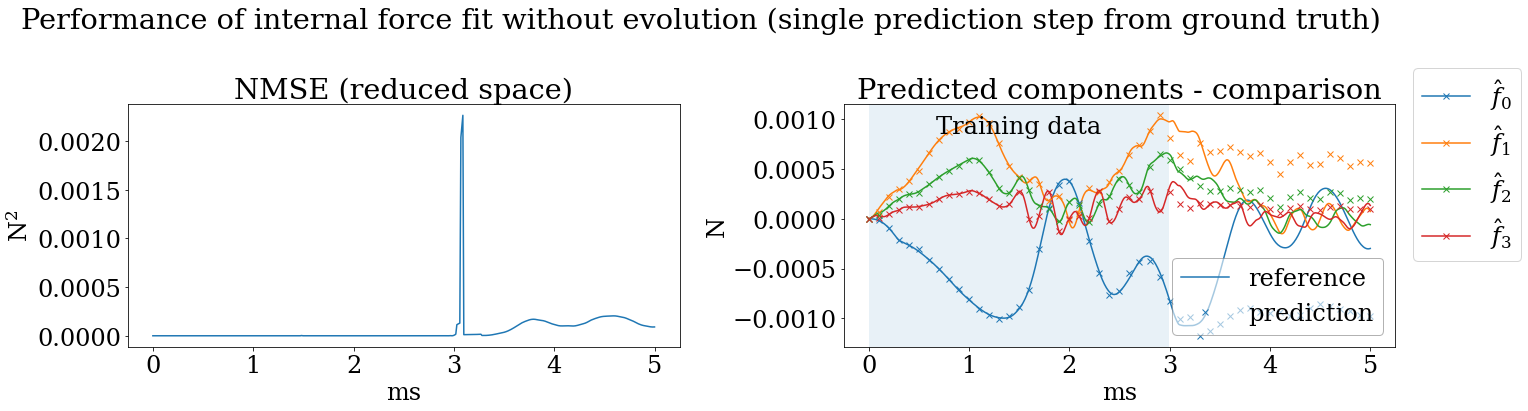

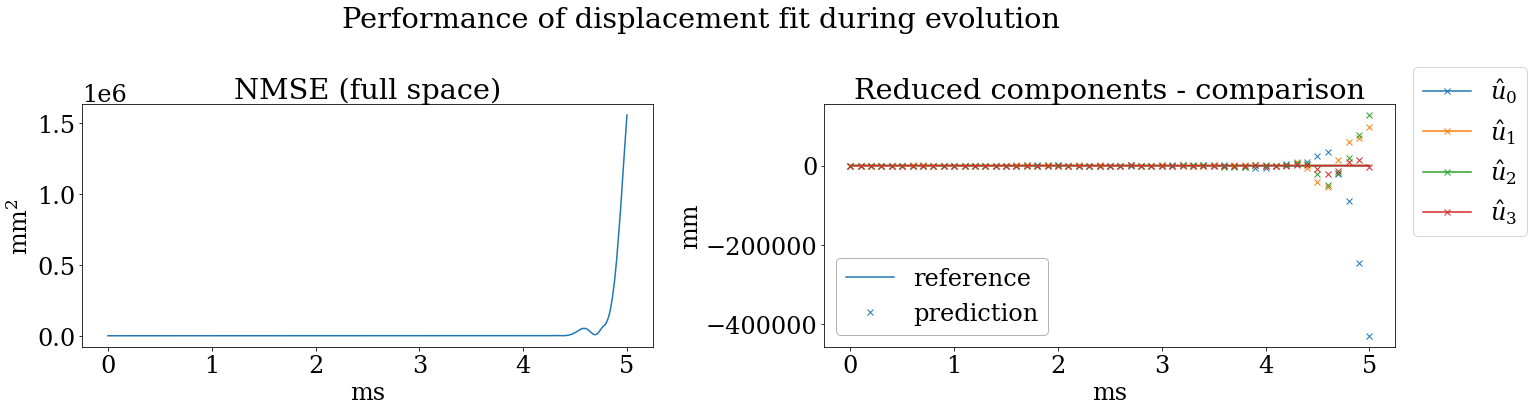

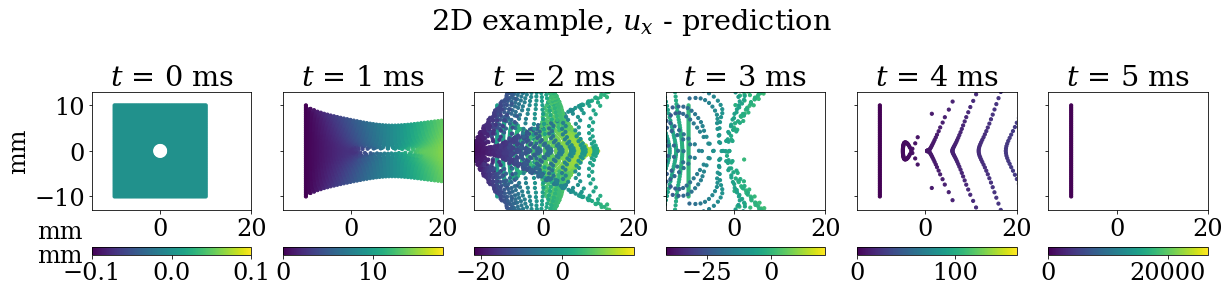

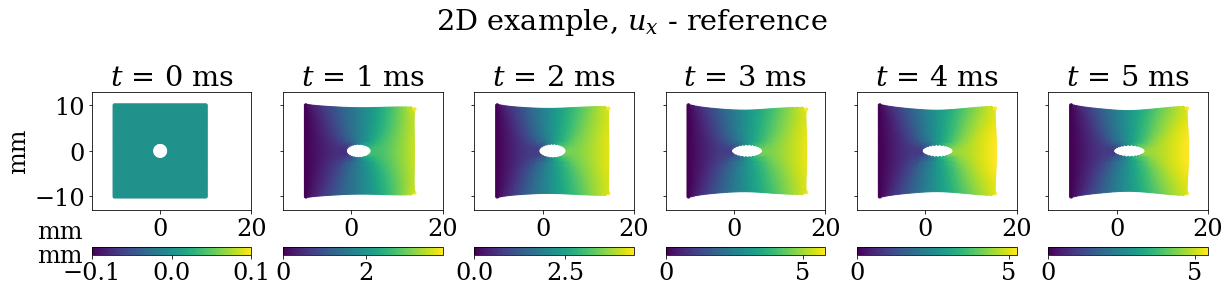

In [110]:
out = evaluate2D(mat2,force_lt_u_pepsoldpepsstep,dr_pepsoldpepsstep_trainfunc, dr_pepsoldpepsstep_trainfunc, dr_pepsoldpepsstep_ar_predfunc,4,training_stop=300,eps_basis_size=npod_eps)

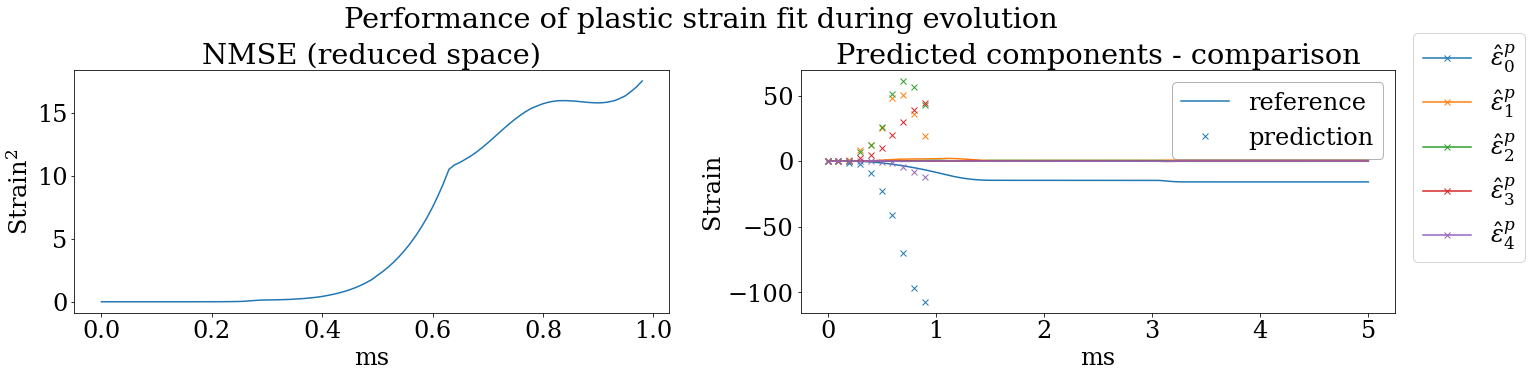

In [111]:
peps_test = out['hist'].peps_r_log[:100]
tt = t[:peps_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((peps_test-mat2.peps_r[:peps_test.shape[0]])**2).mean(axis=1)/(peps_test.max()-peps_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.peps_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],peps_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}^p_{{{i}}}$") for i in range(mat2.peps_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of plastic strain fit during evolution',y=0.9)
plt.tight_layout();

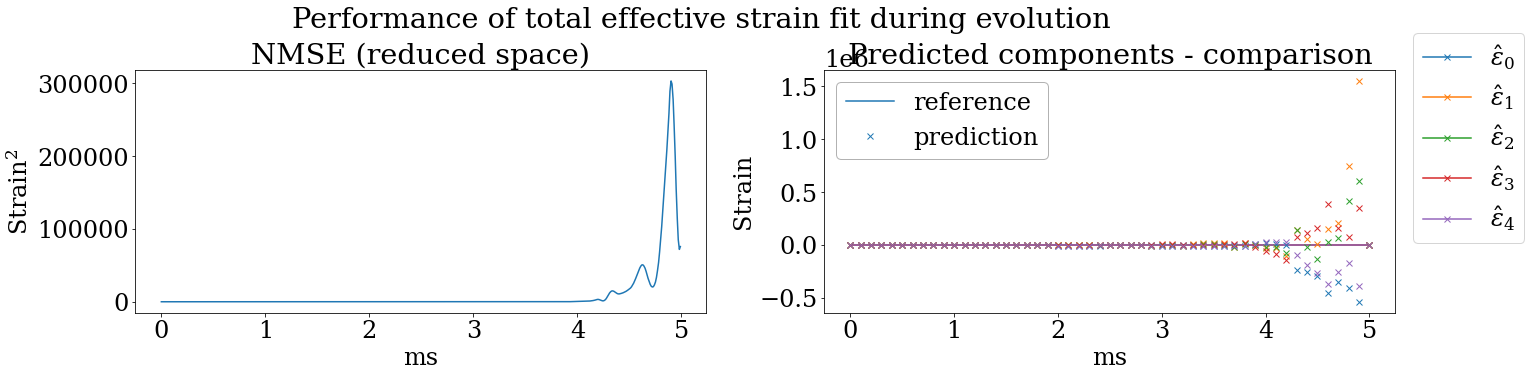

In [105]:
epsbar_test = out['hist'].epsbar_r_log[:]
tt = t[:epsbar_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((epsbar_test-mat2.epsbar_r[:epsbar_test.shape[0]])**2).mean(axis=1)/(epsbar_test.max()-epsbar_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.epsbar_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],epsbar_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}_{{{i}}}$") for i in range(mat2.epsbar_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of total effective strain fit during evolution',y=0.9)
plt.tight_layout();

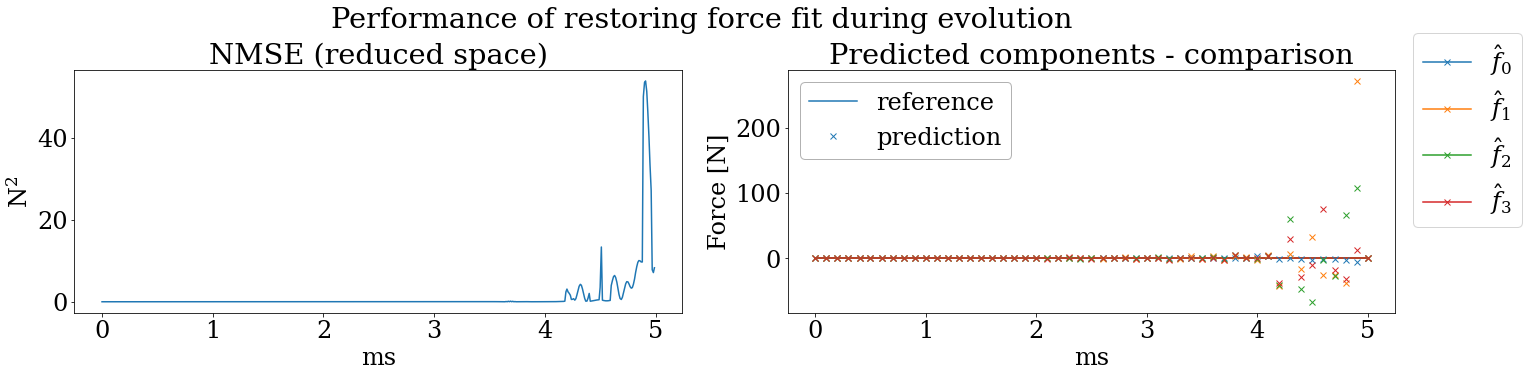

In [106]:
fint_test = out['hist'].fint_r_log[:]
tt = t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit during evolution',y=0.9)
plt.tight_layout();

More straightforwad but less stable

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	LinearTreeRegressor(base_estimator=SymmetricRidge(alpha=0.5), criterion='mae',
                    linear_features=range(0, 4), min_samples_leaf=16)(Reduced displacement augmented with the effective plastic strain, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain, strain from displacement
	POD components:	4
	Training range:	0:300/501


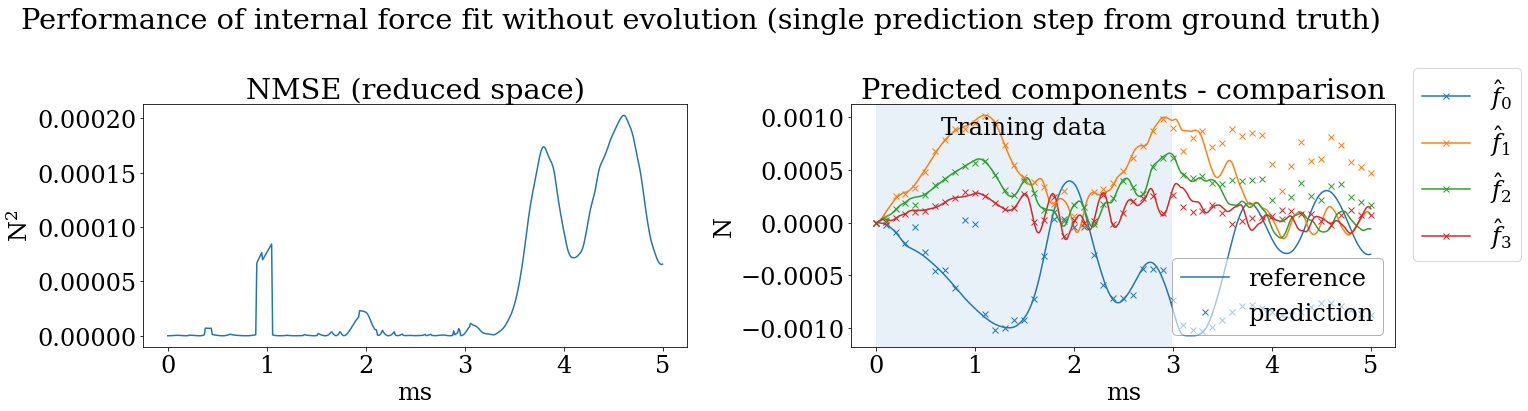

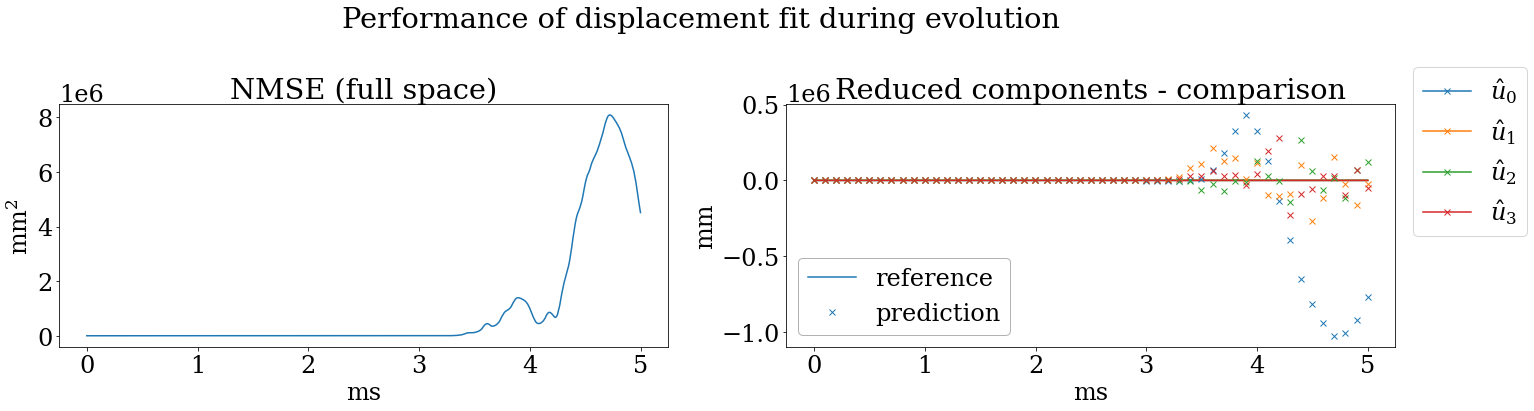

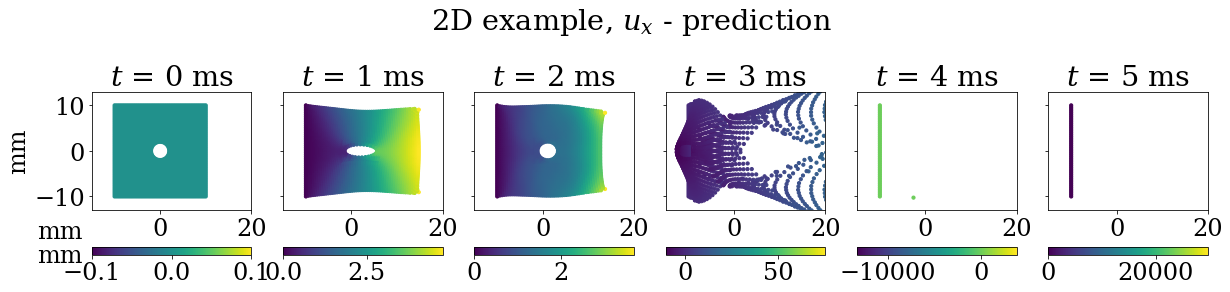

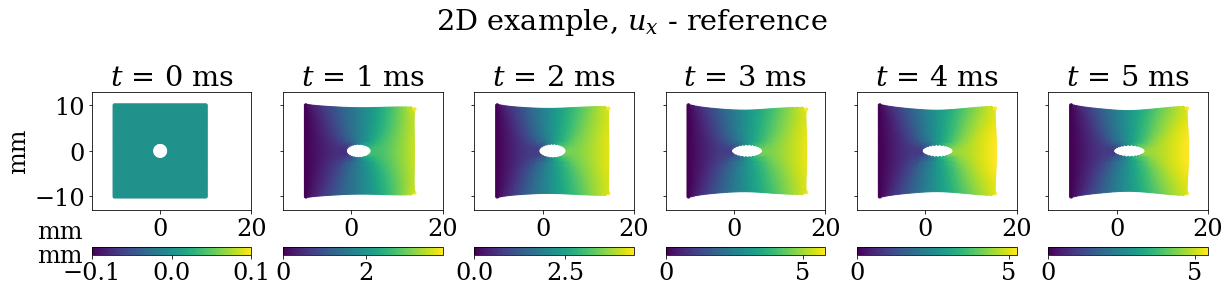

In [129]:
out = evaluate2D(mat2,force_ltsym_u_all,dr_peps_trainfunc, dr_peps_trainfunc, dr_peps_ar_predfunc,4,training_stop=300,eps_basis_size=npod_eps)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	LinearTreeRegressor(base_estimator=SymmetricRidge(alpha=0.5), criterion='mae',
                    linear_features=range(0, 4), min_samples_leaf=16)(Reduced displacement augmented with the effective plastic strain, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain from delta, strain from displacement and delay
	POD components:	4
	Training range:	0:300/501


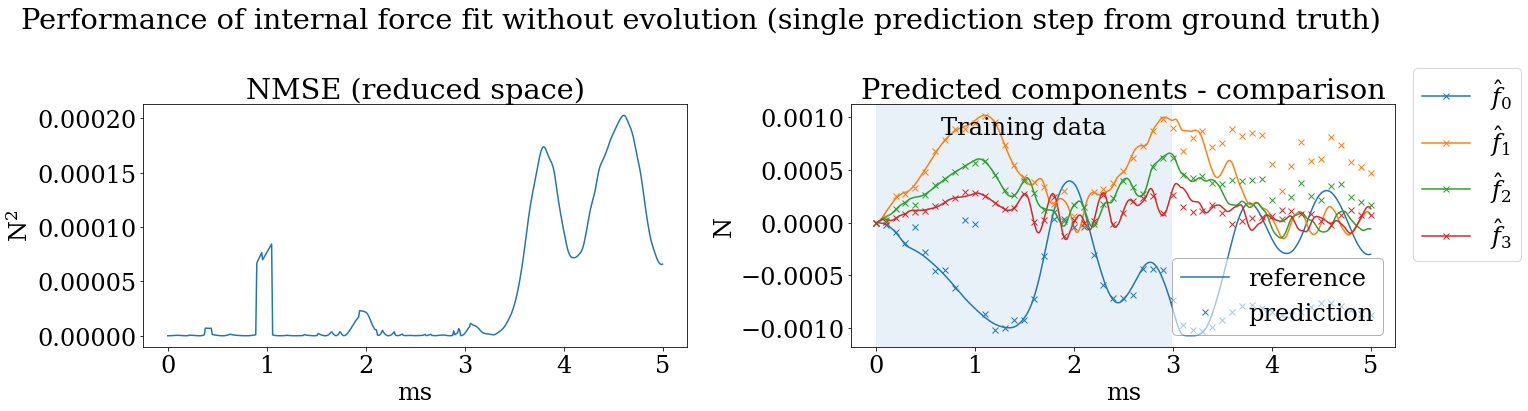

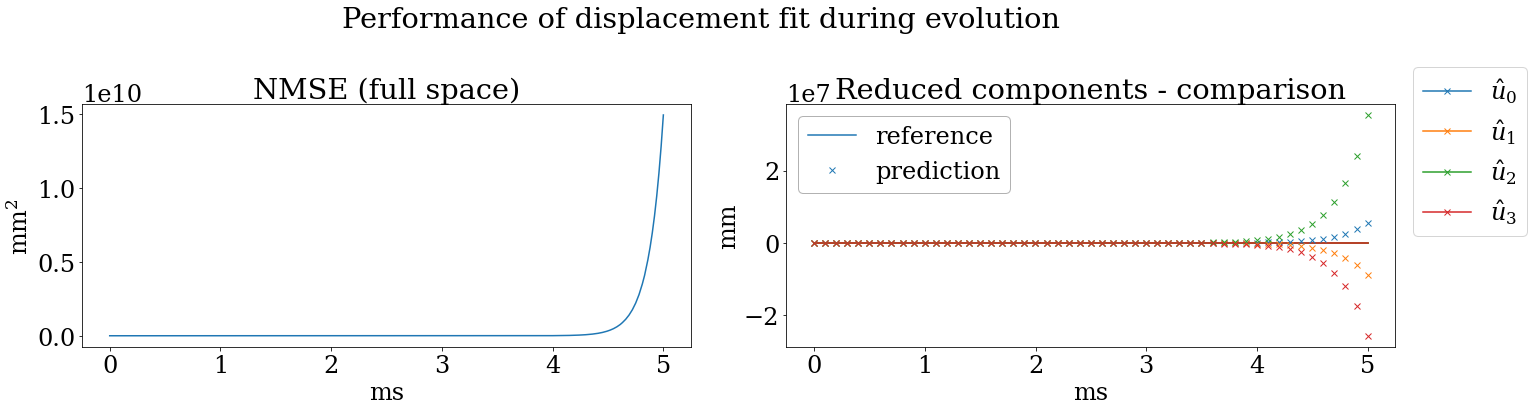

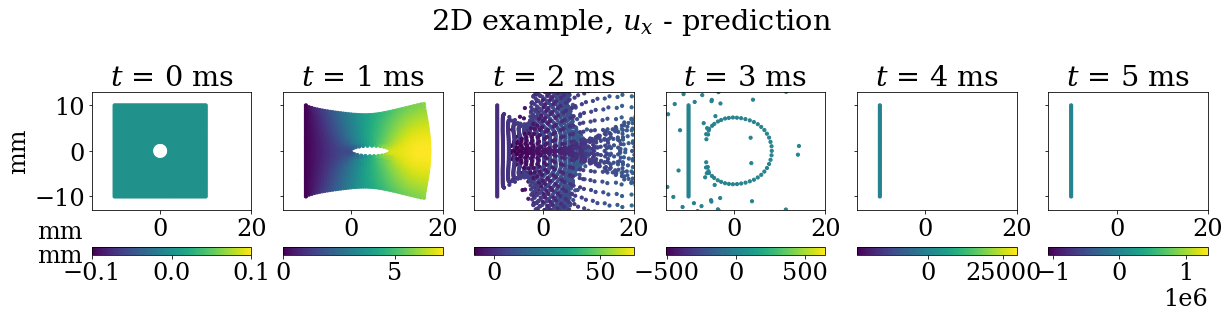

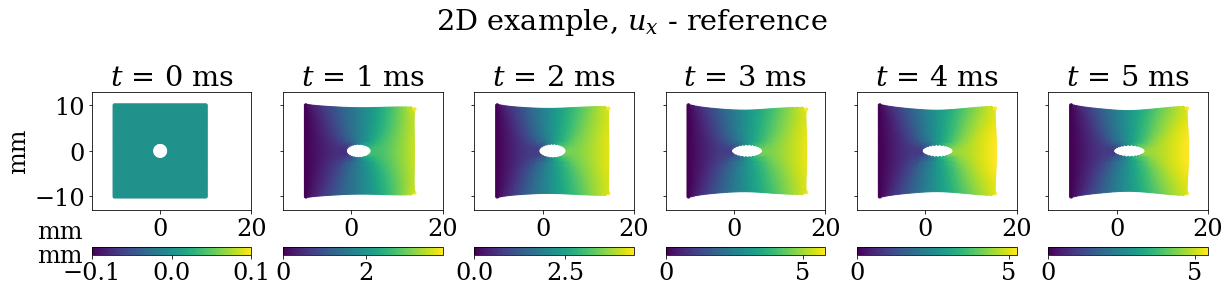

In [125]:
out = evaluate2D(mat2,force_ltsym_u_all,dr_peps_trainfunc, dr_peps_trainfunc, dr_pepsdelta_delay_ar_predfunc,4,training_stop=300,eps_basis_size=npod_eps)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	LinearTreeRegressor(base_estimator=SymmetricRidge(alpha=0.5), criterion='mae',
                    linear_features=range(0, 4), min_samples_leaf=16)(Reduced displacement augmented with the effective plastic strain, its past value and the step between, Reduced Internal force)
	Acceleration function:	Reduced displacement augmented with the effective plastic strain, its past value and the step between
	POD components:	4
	Training range:	0:300/501


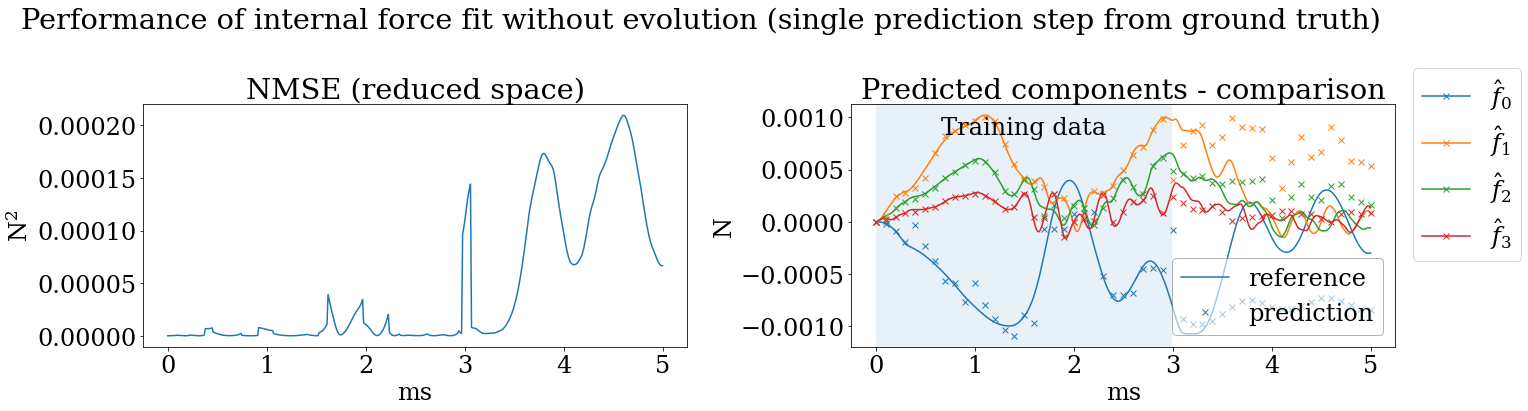

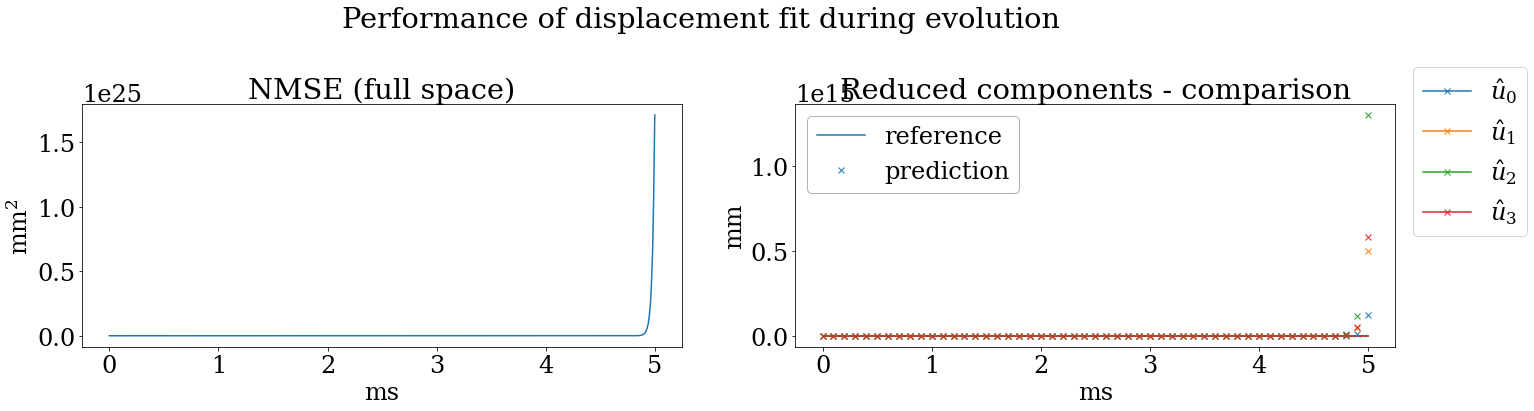

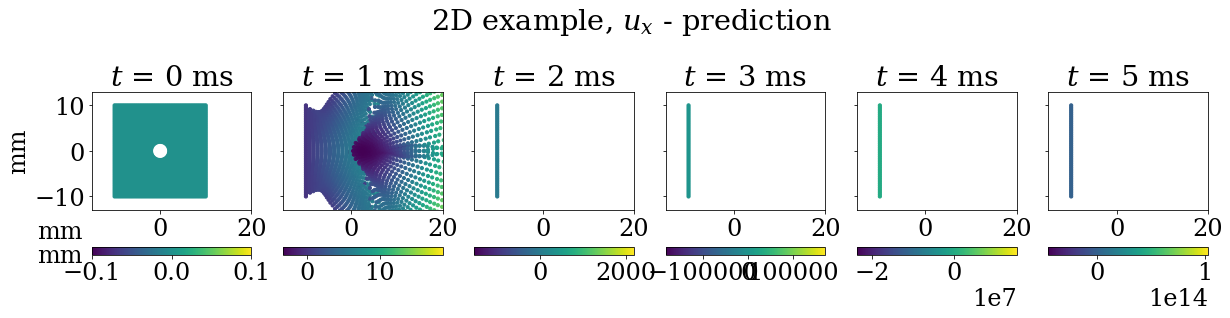

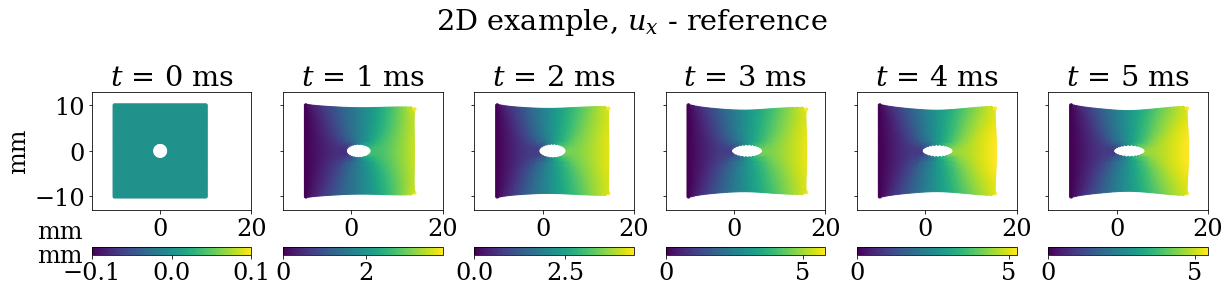

In [135]:
out = evaluate2D(mat2,force_ltsym_u_all,dr_pepsoldpepsstep_trainfunc, dr_pepsoldpepsstep_trainfunc, dr_pepsoldpepsstep2_ar_predfunc,4,training_stop=300,eps_basis_size=npod_eps)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	LinearTreeRegressor(base_estimator=Ridge(alpha=0.2, fit_intercept=False),
                    criterion='mae', min_samples_leaf=16)(Reduced displacement augmented with the effective plastic strain, its past value and the step between, Reduced Internal force)
	Acceleration function:	Reduced displacement augmented with the effective plastic strain, its past value and the step between
	POD components:	4
	Training range:	0:300/501


c:\Users\etodorov\anaconda3\envs\fem\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.52838e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\etodorov\anaconda3\envs\fem\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.97152e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\etodorov\anaconda3\envs\fem\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.25636e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\etodorov\anaconda3\envs\fem\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.56428e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\etodorov\anaconda3\envs\fem\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-condit

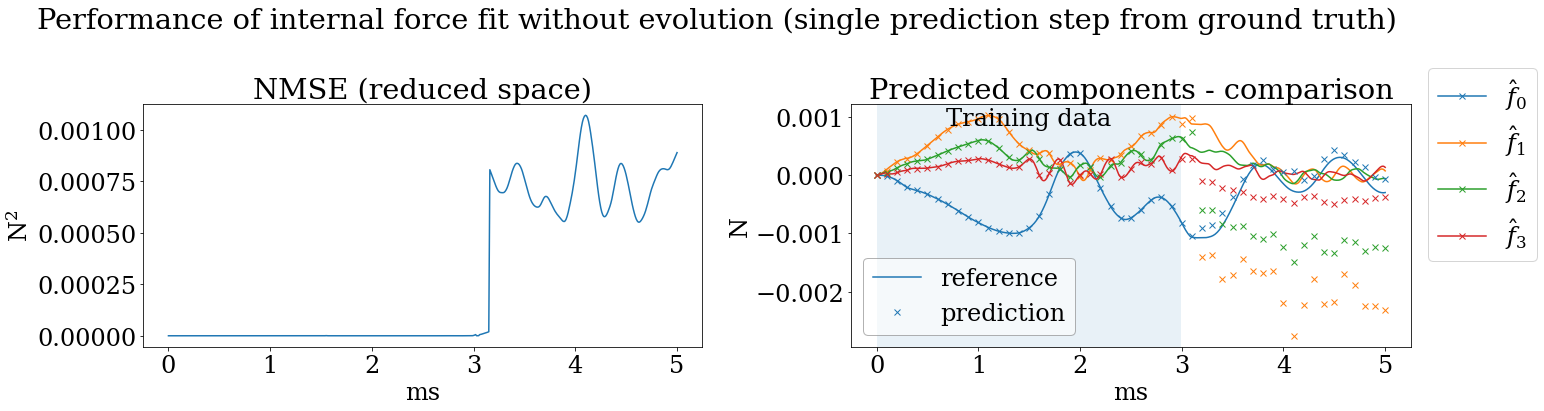

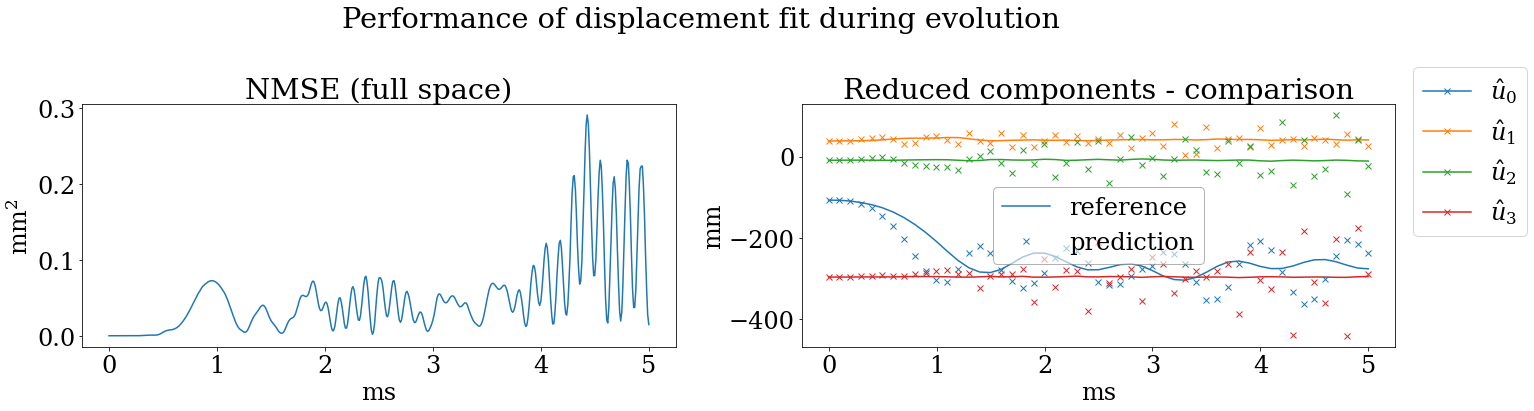

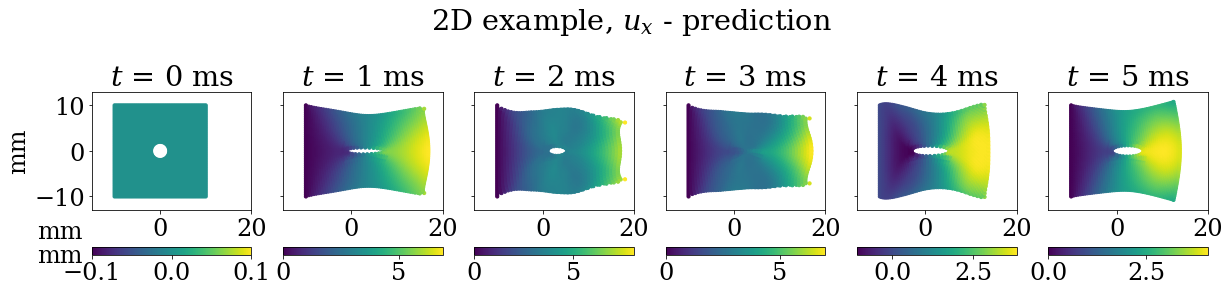

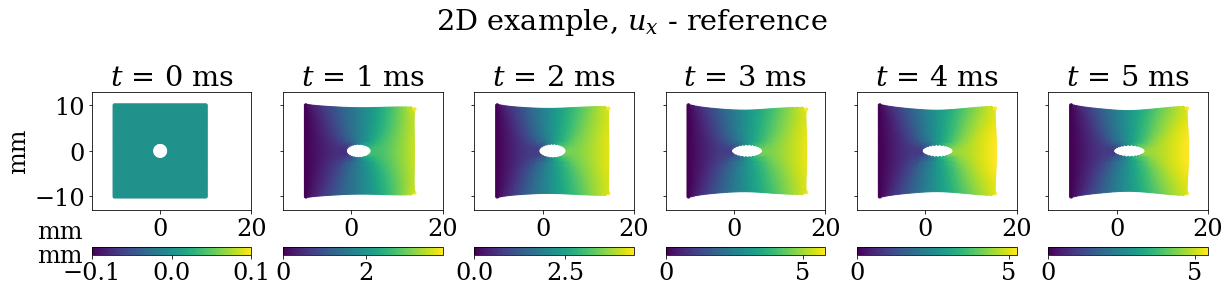

In [142]:
out = evaluate2D(mat2,force_lt_all_all,dr_pepsoldpepsstep_trainfunc, dr_pepsoldpepsstep_trainfunc, dr_pepsoldpepsstep2_ar_predfunc,4,training_stop=300,eps_basis_size=npod_eps)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	LinearTreeRegressor(base_estimator=Ridge(alpha=0.2, fit_intercept=False),
                    criterion='mae', min_samples_leaf=16)(Reduced displacement augmented with the effective plastic strain, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain, strain from displacement and delay
	POD components:	4
	Training range:	0:300/501


c:\Users\etodorov\anaconda3\envs\fem\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.25374e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\etodorov\anaconda3\envs\fem\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.65501e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\etodorov\anaconda3\envs\fem\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.16916e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\etodorov\anaconda3\envs\fem\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.85165e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
c:\Users\etodorov\anaconda3\envs\fem\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-condit

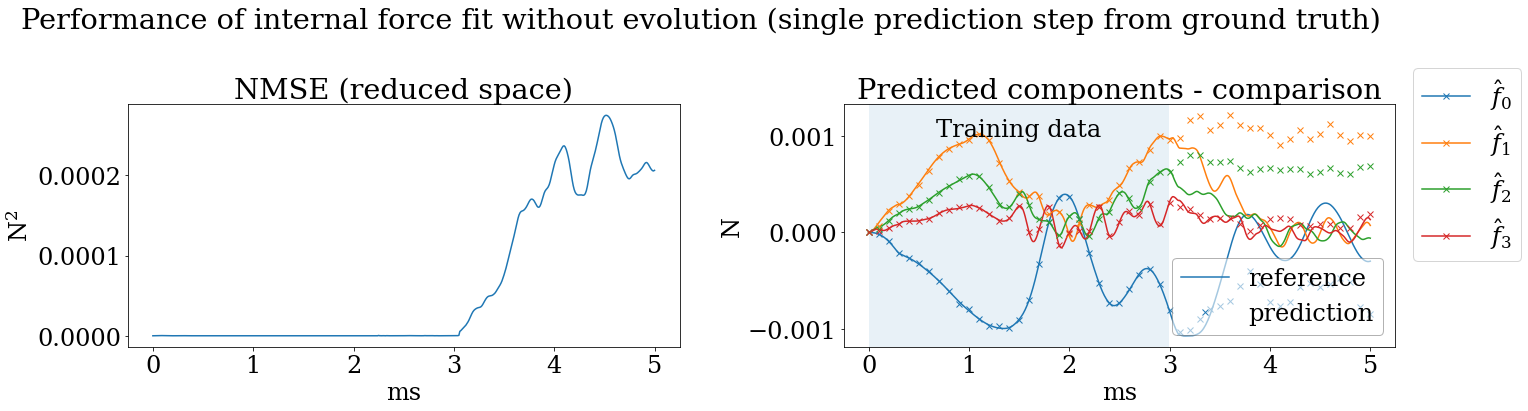

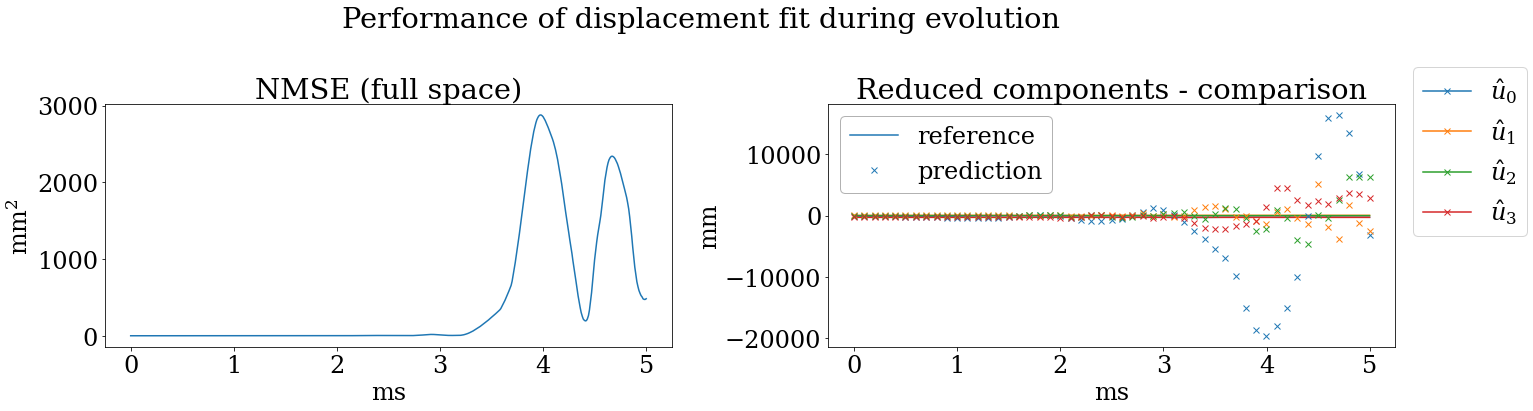

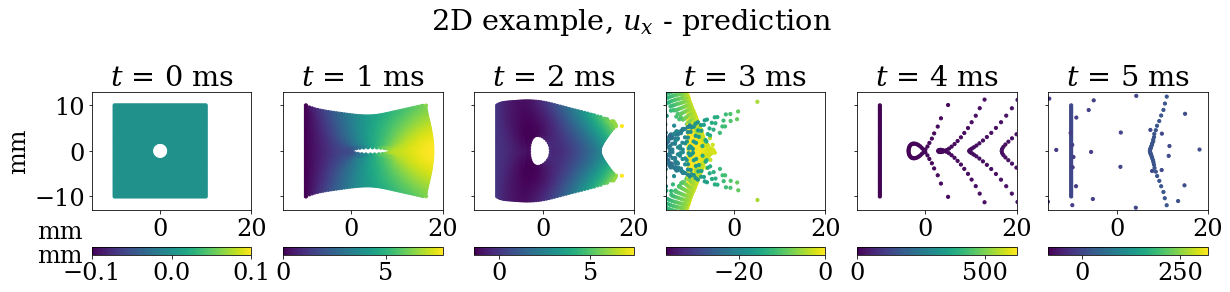

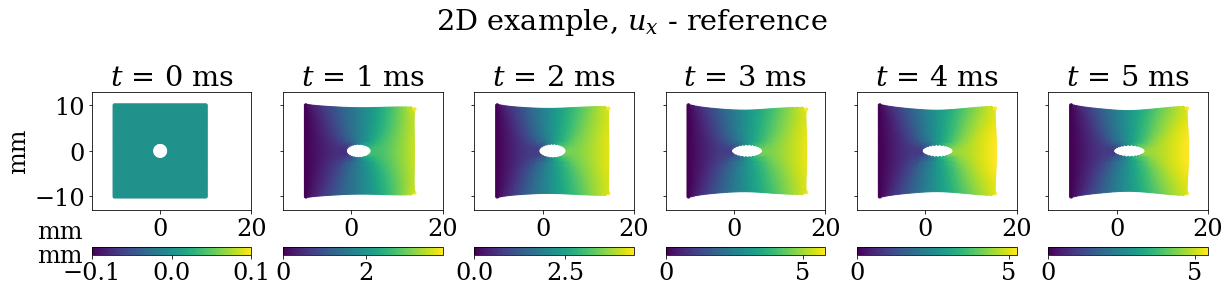

In [141]:
out = evaluate2D(mat2,force_lt_all_all,dr_peps_trainfunc, dr_peps_trainfunc, dr_peps_delay_ar_predfunc,4,training_stop=300,eps_basis_size=npod_eps)